In [8]:
using Revise
using GLMakie
using Arya

[ Info: Precompiling Arya [415bc928-4679-4905-9aff-233f9524af88]
[ Info: Precompiling AryaMeasurementsExt [2f77244d-f0f4-5d92-99ae-56f9b7abc771]


In [9]:
import DensityEstimators as DE

In this notebook, I investigate some methods for calculating the density :)

In [209]:
import Distributions: Normal, pdf, Distributions

In [11]:
using Optim

In [12]:
import StatsBase: quantile

# Distributions

In [222]:
dist_normal = Normal(0., π/3)

Normal{Float64}(μ=0.0, σ=1.0471975511965976)

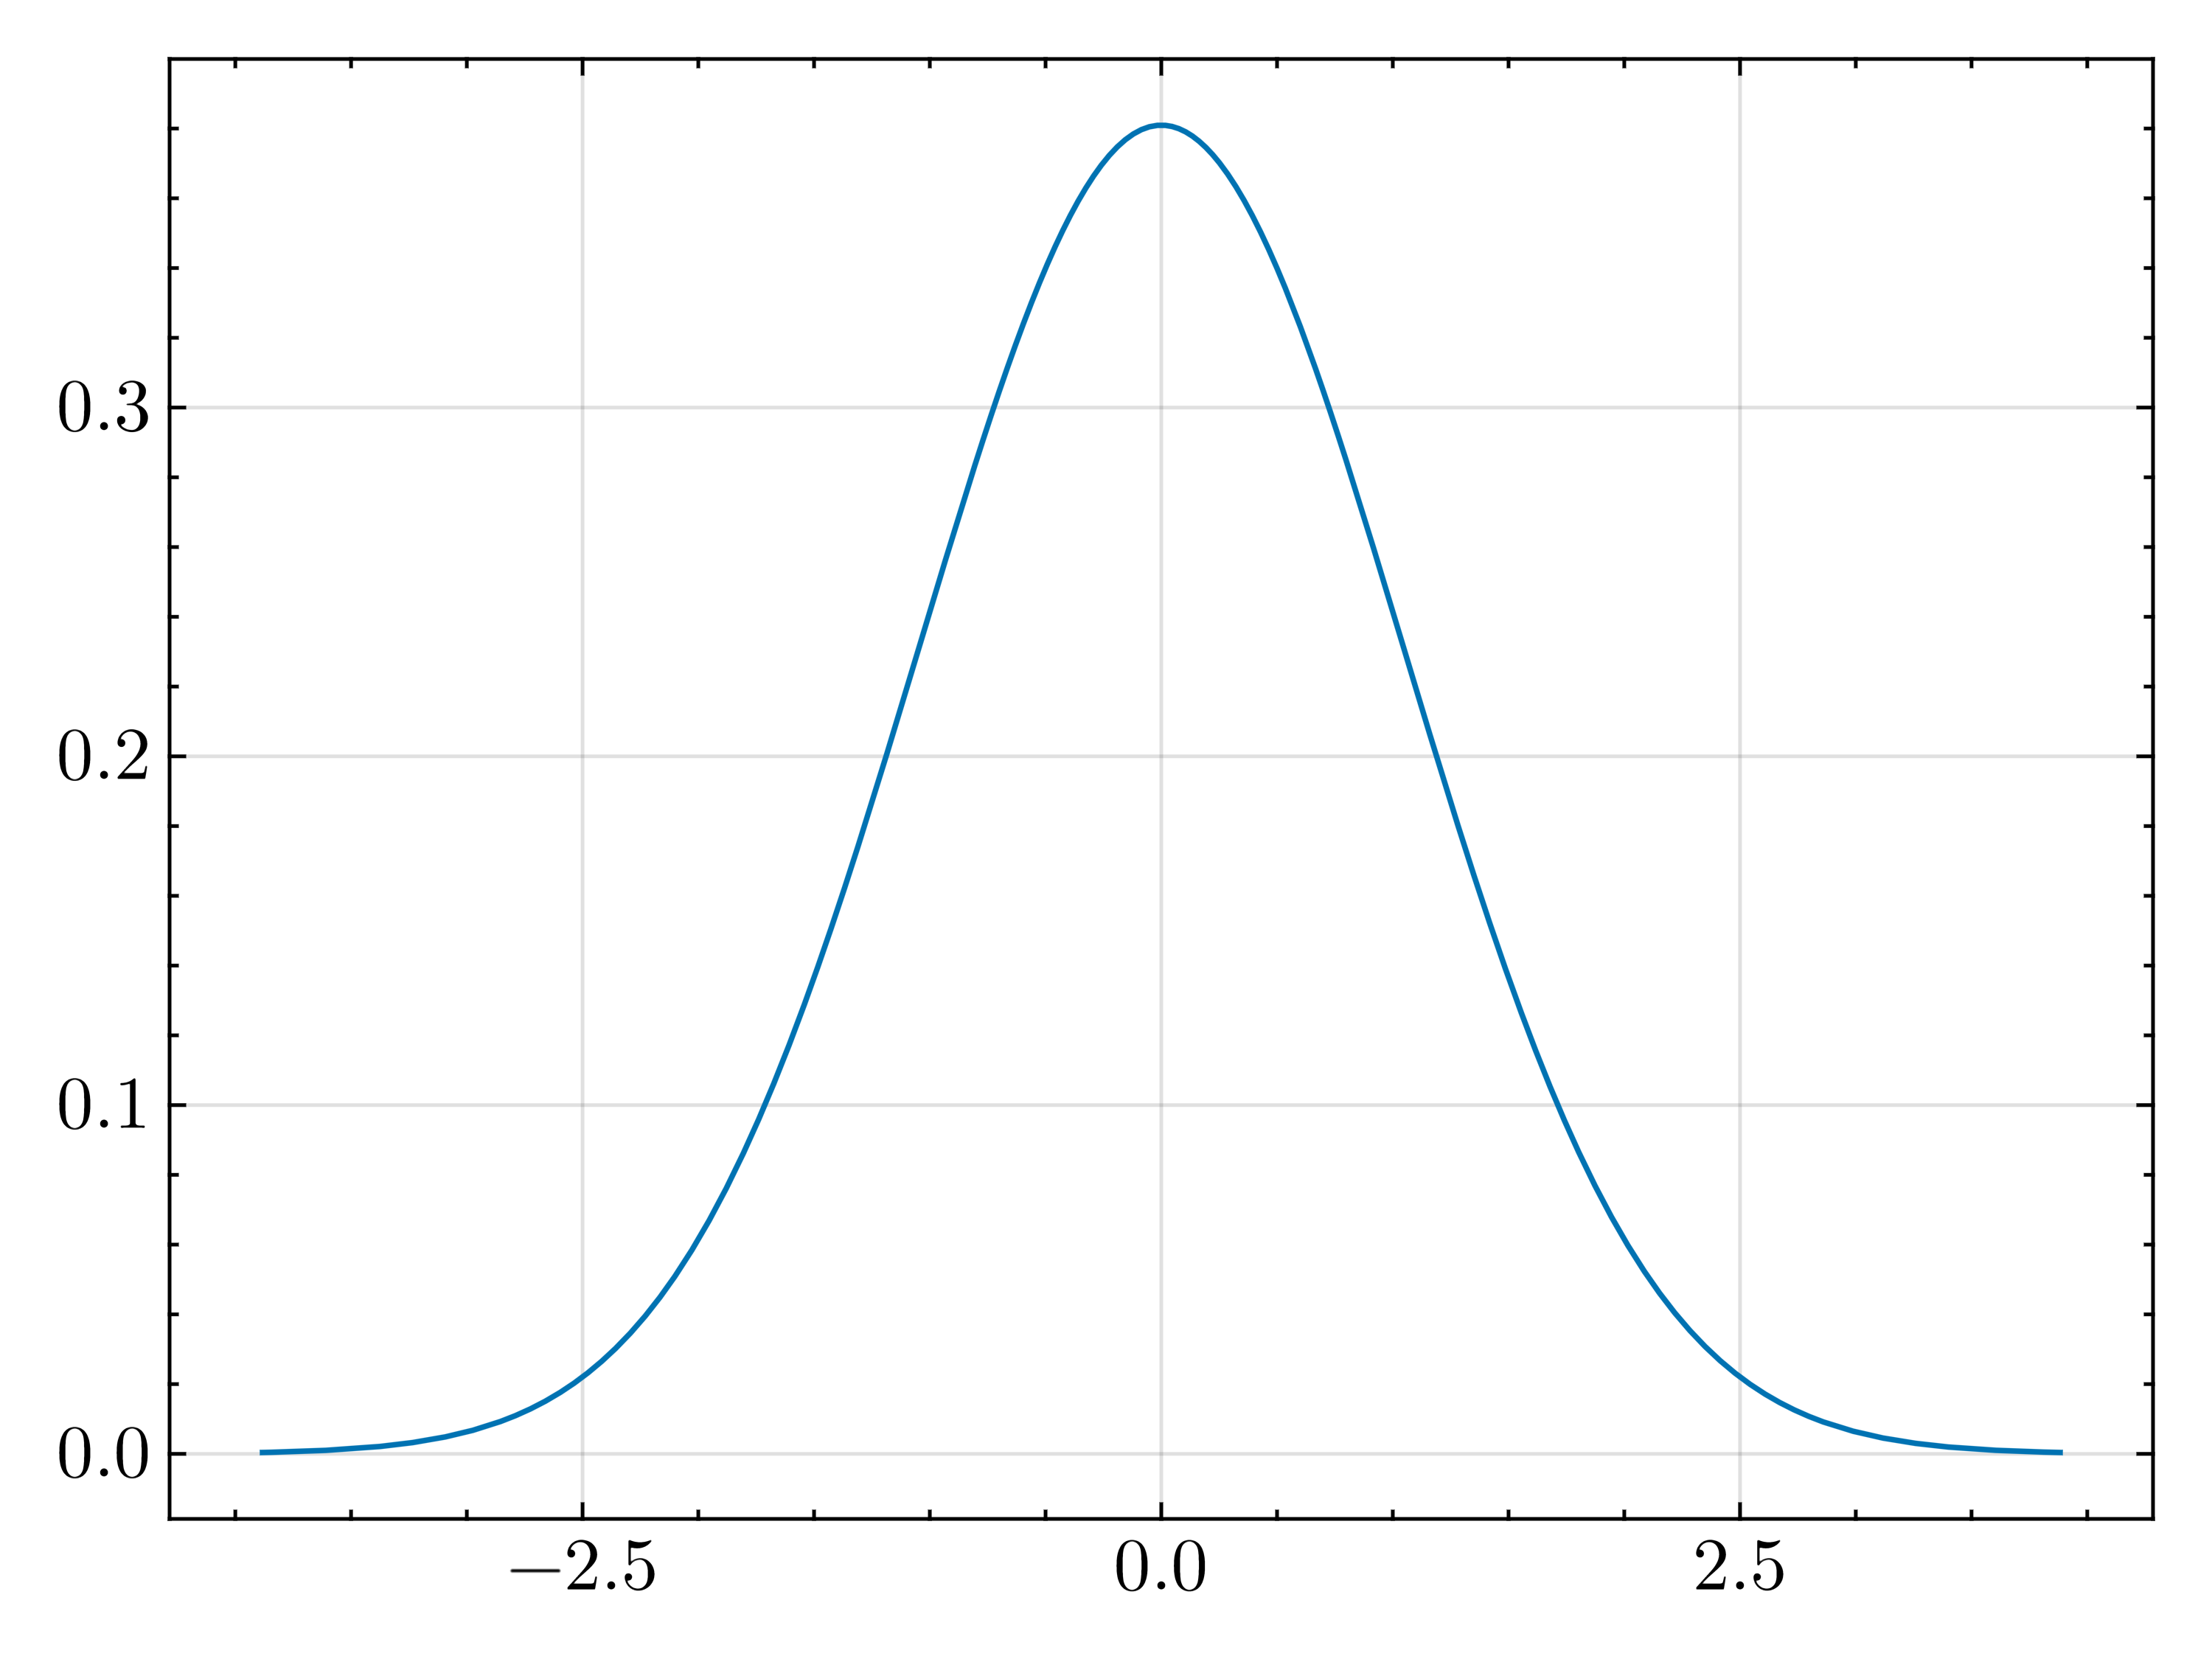

In [223]:
plot(dist_normal)

In [415]:
function plot_derivative!(dist, x=LinRange(-5, 5, 10000))
    y = pdf.(dist, x)
    y1 = DE.gradient(y, x)

    lines!(x, y1)
end


plot_derivative! (generic function with 2 methods)

In [416]:
function plot_d2!(dist, x=LinRange(-5, 5, 10000))
    y = pdf.(dist, x)
    y1 = DE.gradient(y, x)
    y2 = DE.gradient(y1, x)
    
    lines!(x, y2)
end


plot_d2! (generic function with 2 methods)

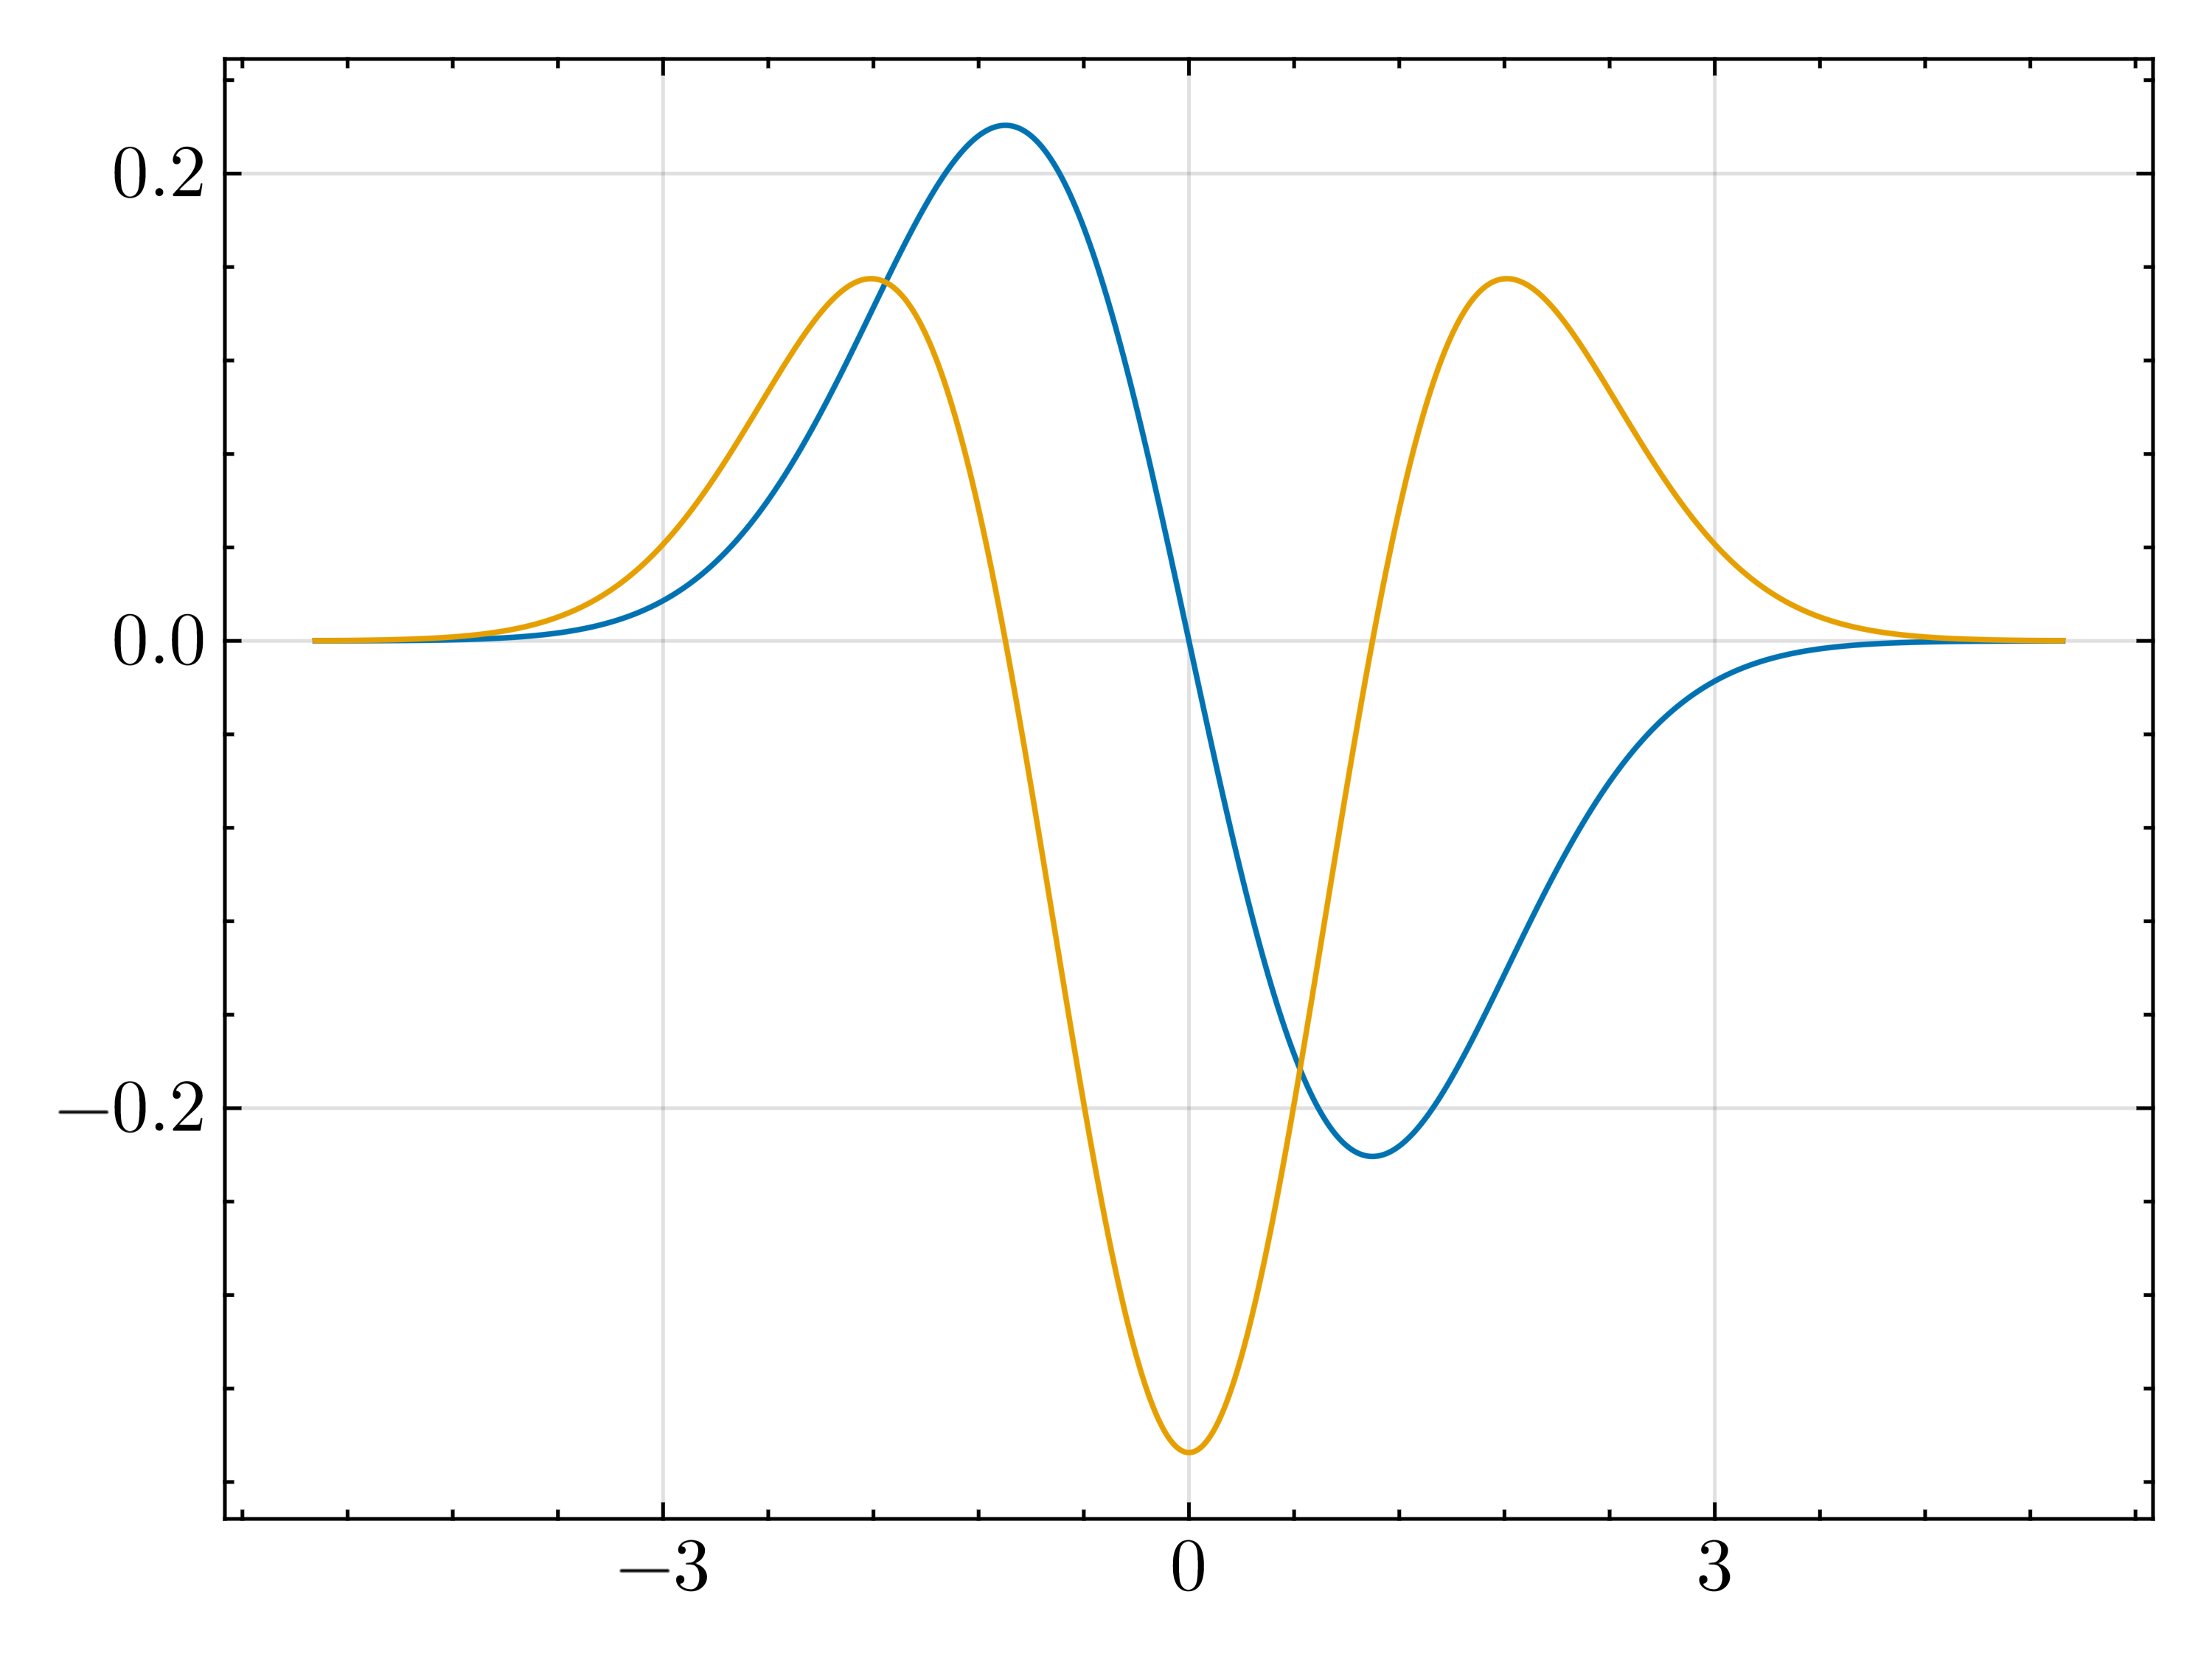

In [417]:
fig, ax = FigAxis()

plot_derivative!(dist_normal)
plot_d2!(dist_normal)

fig

# BSpline

In [279]:
N = 10_000
x = rand(dist_normal, N);

## Primal spline

In [230]:
Nk = 60
k_0 = LinRange(minimum(x), maximum(x), Nk)
#k_0 = quantile(x, LinRange(0, 1, Nk));

degree = 3

3

In [231]:
s = DE.PrimalBSpline(x, k_0, degree=degree)

DensityEstimators.BSpline(62-element Spline{Float64}:
 basis: 62-element BSplineBasis of order 4, domain [-6.384522923097085, 8.270521246419408]
 order: 4
 knots: [-6.38452, -6.38452, -6.38452, -6.38452, -6.13613, -5.88774, -5.63935, -5.39096, -5.14257, -4.89418  …  6.78018, 7.02857, 7.27696, 7.52535, 7.77374, 8.02213, 8.27052, 8.27052, 8.27052, 8.27052]
 coefficients: [6.70993e-6, 2.68397e-5, 6.97248e-6, 1.527e-5, 4.84565e-5, 0.000101595, 0.000192067, 0.000219646, 0.00032082, 0.00063146  …  0.000977477, 0.000467515, 0.000366989, 0.000178572, 0.000114388, 4.94561e-5, 3.30802e-6, 6.70993e-6, 2.68397e-5, 6.70993e-6])

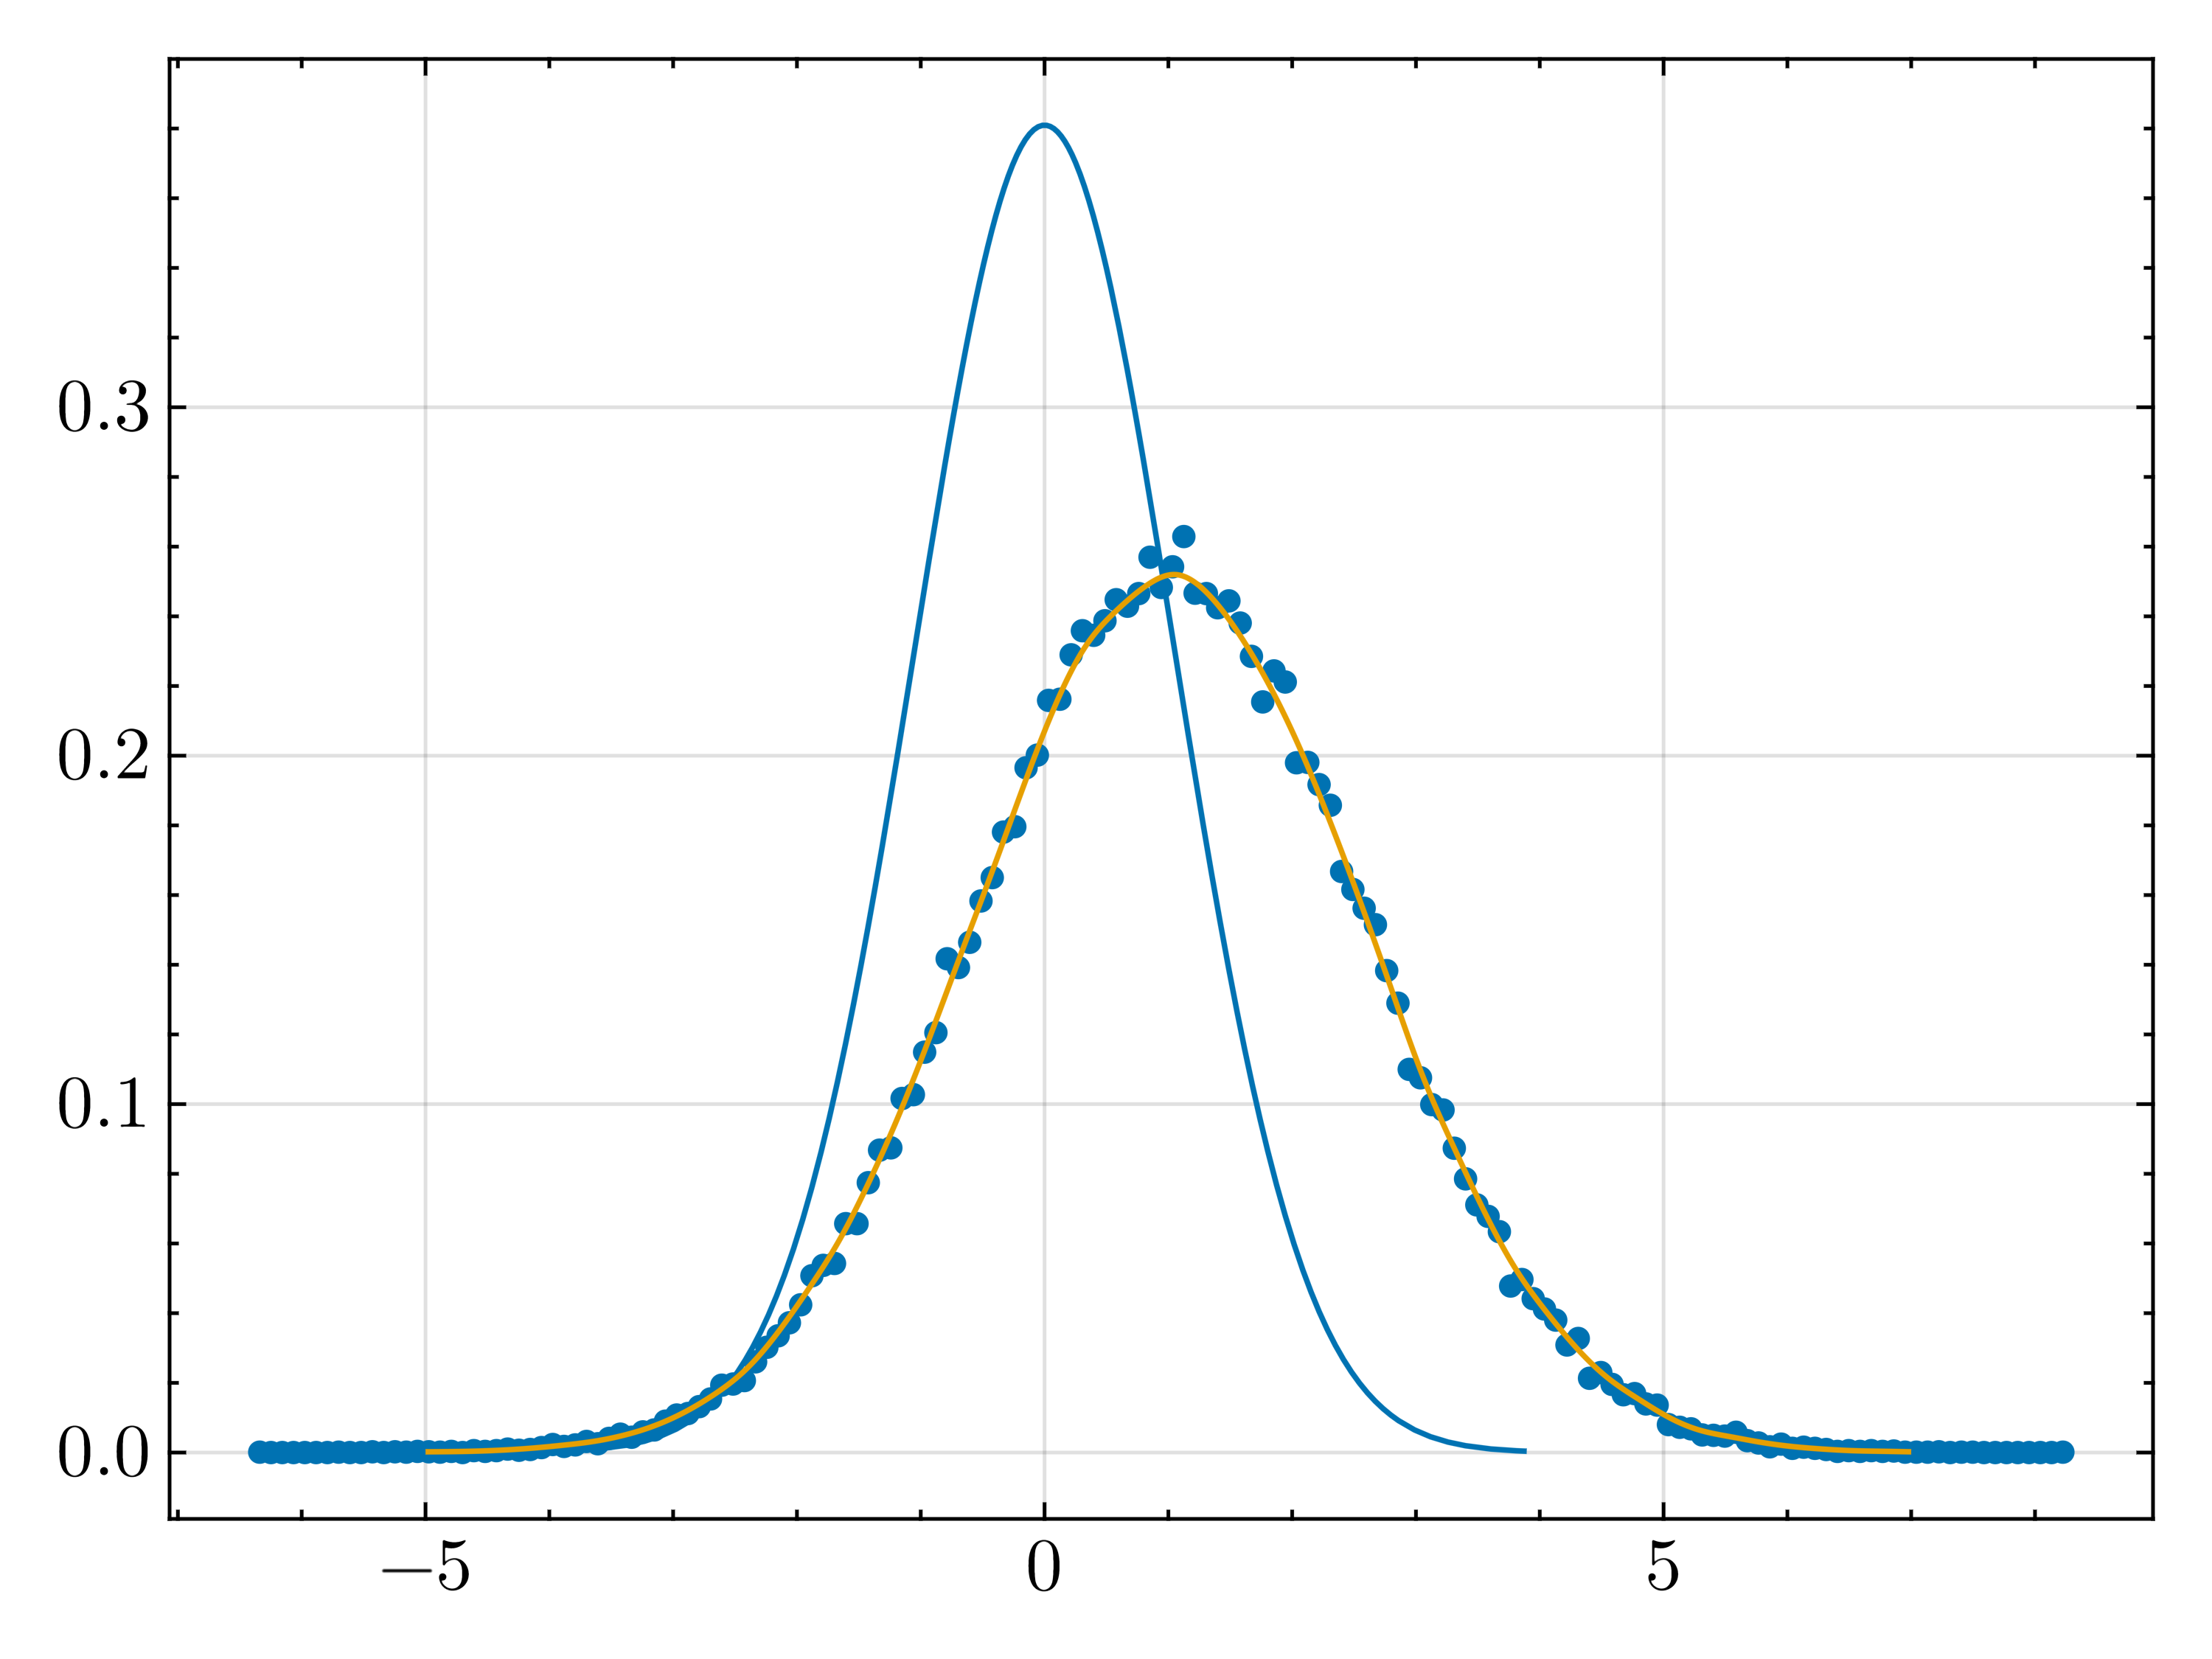

In [232]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
plot!(midpoints(h.bins), h.values)

plot!(dist_normal)

x_m = LinRange(-5, 7, 1000)
y = s.(x_m)
lines!(x_m, y)

fig

## Series approximated duals

In [838]:
function log_L(spline, x; s=0.001, λ=3)
    
    N = length(x)
    s_x = spline.(x)
    if any(s_x .< 0)
        return -Inf
    end
    
    A = DE.integral(spline)(spline.knots[end])
    return 1/N * sum(log.(s_x)) - λ * abs.(log.(A)) - 1/2 * s * sum(spline.coefs .^ 2)
end

log_L (generic function with 2 methods)

In [894]:
function optimize_spline(knots, coef_i, degree, samples)
    k2 = DE.pad_knots(knots, degree)
    
    function ϕ(k)
        return DE.bspline_basis.([k2], k, degree, samples)
    end
    
    ϕs = [ϕ(k) for k in 1:length(coef_i)]
    
    function fgh!(F, G, H, coef)
        s = DE.BSpline(knots, coef, degree)
        f =  s.(samples) 

        if F !== nothing
            F = -log_L(s, samples, λ=2, s=0) 
        end
        
        if G !== nothing
            for i in 1:length(coef)
                G[i] = sum(1 ./ f .* ϕs[i])
            end 
        end
    
        if H !== nothing
            for i in 1:length(coef)
                for j in 1:length(coef)
                    H[i, j] = sum(- 1 ./ f .^2 .* ϕs[i] .* ϕs[j])
                end
            end 
        end
    
        nothing
    end
        
    result = optimize(Optim.only_fgh!(fgh!), coef_i, BFGS())
    
    return result.minimizer, result
end

optimize_spline (generic function with 1 method)

In [895]:
Nk = 10
k_0 = quantile(x, LinRange(0, 1, Nk))
k_0 = LinRange(minimum(x), maximum(x), Nk)
a_0 = 1/Nk * rand(length(k_0) + 2)
c0_0 = 1

1

In [896]:
s_primal = DE.PrimalBSpline(x, k_0, degree=degree)

DensityEstimators.BSpline(12-element Spline{Float64}:
 basis: 12-element BSplineBasis of order 4, domain [-4.097646682818083, 4.5630902002569105]
 order: 4
 knots: [-4.09765, -4.09765, -4.09765, -4.09765, -3.13534, -2.17304, -1.21073, -0.24843, 0.713874, 1.67618, 2.63848, 3.60079, 4.56309, 4.56309, 4.56309, 4.56309]
 coefficients: [3.43335e-5, 0.000834076, 0.0103044, 0.0640945, 0.204856, 0.328942, 0.279303, 0.123036, 0.028403, 0.00304481, 0.000190297, 1.83661e-5])

In [897]:
a_0 = DE.PrimalBSpline(x, k_0, degree=degree).coefs;

In [899]:
a, result = optimize_spline(k_0, a_0, 3, x)
result

LoadError: MethodError: [0mCannot `convert` an object of type [92mNothing[39m[0m to an object of type [91mFloat64[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Level[39m) where T<:Real
[0m[90m   @[39m [36mUnitful[39m [90m~/.julia/packages/Unitful/GYzMo/src/[39m[90m[4mlogarithm.jl:22[24m[39m
[0m  convert(::Type{T}, [91m::Quantity[39m) where T<:Real
[0m[90m   @[39m [36mUnitful[39m [90m~/.julia/packages/Unitful/GYzMo/src/[39m[90m[4mconversion.jl:139[24m[39m
[0m  convert(::Type{T}, [91m::IntervalArithmetic.ExactReal[39m) where T<:Real
[0m[90m   @[39m [33mIntervalArithmetic[39m [90m~/.julia/packages/IntervalArithmetic/hLM2A/src/intervals/[39m[90m[4mexact_literals.jl:111[24m[39m
[0m  ...


In [888]:
s_best = DE.BSpline(k_0, a, 3)

DensityEstimators.BSpline(12-element Spline{Float64}:
 basis: 12-element BSplineBasis of order 4, domain [-4.097646682818083, 4.5630902002569105]
 order: 4
 knots: [-4.09765, -4.09765, -4.09765, -4.09765, -3.13534, -2.17304, -1.21073, -0.24843, 0.713874, 1.67618, 2.63848, 3.60079, 4.56309, 4.56309, 4.56309, 4.56309]
 coefficients: [0.00369128, -0.00752668, 0.0156801, 0.000834901, 0.241389, 0.377044, 0.337169, 0.0668538, 0.00733904, -0.000733949, 0.000131019, 0.000439157])

In [424]:
sum(a)

1.0423105464489013

In [427]:
sum(s_best._spline.coefs)

1.043061562274068

In [429]:
DE.integral(s_best)(k_0[end])

0.9999999999999999

In [477]:
DE.bspline_basis(k_0, length(k_0) - degree - 1, degree, k_0[end])

0.0

In [806]:
function spline_area(spline)
    t = spline.knots
    a = spline.coefs
    d = spline.degree
    
    S = length(a)
    x = t[S+1]
    
    alphas = get_int_coefs(spline)
    
    return DE.eval_spline([t[1]; t; t[end]], alphas, d+1, x)
    
end

spline_area (generic function with 1 method)

In [855]:
function get_int_coefs(spline)
    t = spline.knots
    a = spline.coefs
    d =spline.degree
    
    S = length(a)
    
    alpha=0
    coefs = zeros(S+1)
    
    for i in 1:S
        alpha += a[i] * (t[i + d]  - t[i]) / d
        
        coefs[i+1] = alpha
    end
    
    return coefs
end

get_int_coefs (generic function with 2 methods)

In [808]:
spline_area(s_best)

0.9999999999999999

In [809]:
c2 = get_int_coefs(s_best,)

13-element Vector{Float64}:
 0.0
 8.25981473870058e-6
 0.0004095772459262958
 0.0078465607474418
 0.06952500298994925
 0.26665912382128565
 0.5832011918762258
 0.8519758720298642
 0.9703741513846401
 0.9977064968896341
 0.9999040199851791
 0.9999955815610196
 0.9999999999999999

In [810]:
DE.BSpline(k_0, c2, 4)(k_0[end])

0.9999999999999999

In [811]:
s_i = DE.integral(s_best)

DensityEstimators.BSpline(13-element Spline{Float64}:
 basis: 13-element BSplineBasis of order 5, domain [-4.097646682818083, 4.5630902002569105]
 order: 5
 knots: [-4.09765, -4.09765, -4.09765, -4.09765, -4.09765, -3.13534, -2.17304, -1.21073, -0.24843, 0.713874, 1.67618, 2.63848, 3.60079, 4.56309, 4.56309, 4.56309, 4.56309, 4.56309]
 coefficients: [0.0, 8.25981e-6, 0.000409577, 0.00784656, 0.069525, 0.266659, 0.583201, 0.851976, 0.970374, 0.997706, 0.999904, 0.999996, 1.0])

In [812]:
DE.eval_spline(s_i.knots, s_i.coefs, 4, s_i.knots[end-4]*0.9999)

0.9999999915634604

In [813]:
s_i.knots

18-element Vector{Float64}:
 -4.097646682818083
 -4.097646682818083
 -4.097646682818083
 -4.097646682818083
 -4.097646682818083
 -3.1353425846986394
 -2.1730384865791956
 -1.2107343884597523
 -0.24843029034030817
  0.7138738077791356
  1.6761779058985788
  2.638482004018023
  3.6007861021374667
  4.5630902002569105
  4.5630902002569105
  4.5630902002569105
  4.5630902002569105
  4.5630902002569105

In [814]:
[s_best.knots]

1-element Vector{BSplineKit.BSplines.AugmentedKnots{Float64, 4, LinRange{Float64, Int64}}}:
 [-4.097646682818083, -4.097646682818083, -4.097646682818083, -4.097646682818083, -3.1353425846986394, -2.1730384865791956, -1.2107343884597523, -0.24843029034030817, 0.7138738077791356, 1.6761779058985788, 2.638482004018023, 3.6007861021374667, 4.5630902002569105, 4.5630902002569105, 4.5630902002569105, 4.5630902002569105]

In [815]:
s_i(s_i.knots[end-4]*0.99999)

0.9999999991613808

In [816]:
s1 = DE.BSpline(k_0, a, 3)

DensityEstimators.BSpline(12-element Spline{Float64}:
 basis: 12-element BSplineBasis of order 4, domain [-4.097646682818083, 4.5630902002569105]
 order: 4
 knots: [-4.09765, -4.09765, -4.09765, -4.09765, -3.13534, -2.17304, -1.21073, -0.24843, 0.713874, 1.67618, 2.63848, 3.60079, 4.56309, 4.56309, 4.56309, 4.56309]
 coefficients: [0.00369128, -0.00752668, 0.0156801, 0.000834901, 0.241389, 0.377044, 0.337169, 0.0668538, 0.00733904, -0.000733949, 0.000131019, 0.000439157])

In [817]:
s2 = x -> DE.eval_spline(s1.knots, s1.coefs, 3, x)

#75 (generic function with 1 method)

In [818]:
s1(2)

0.05741534519549134

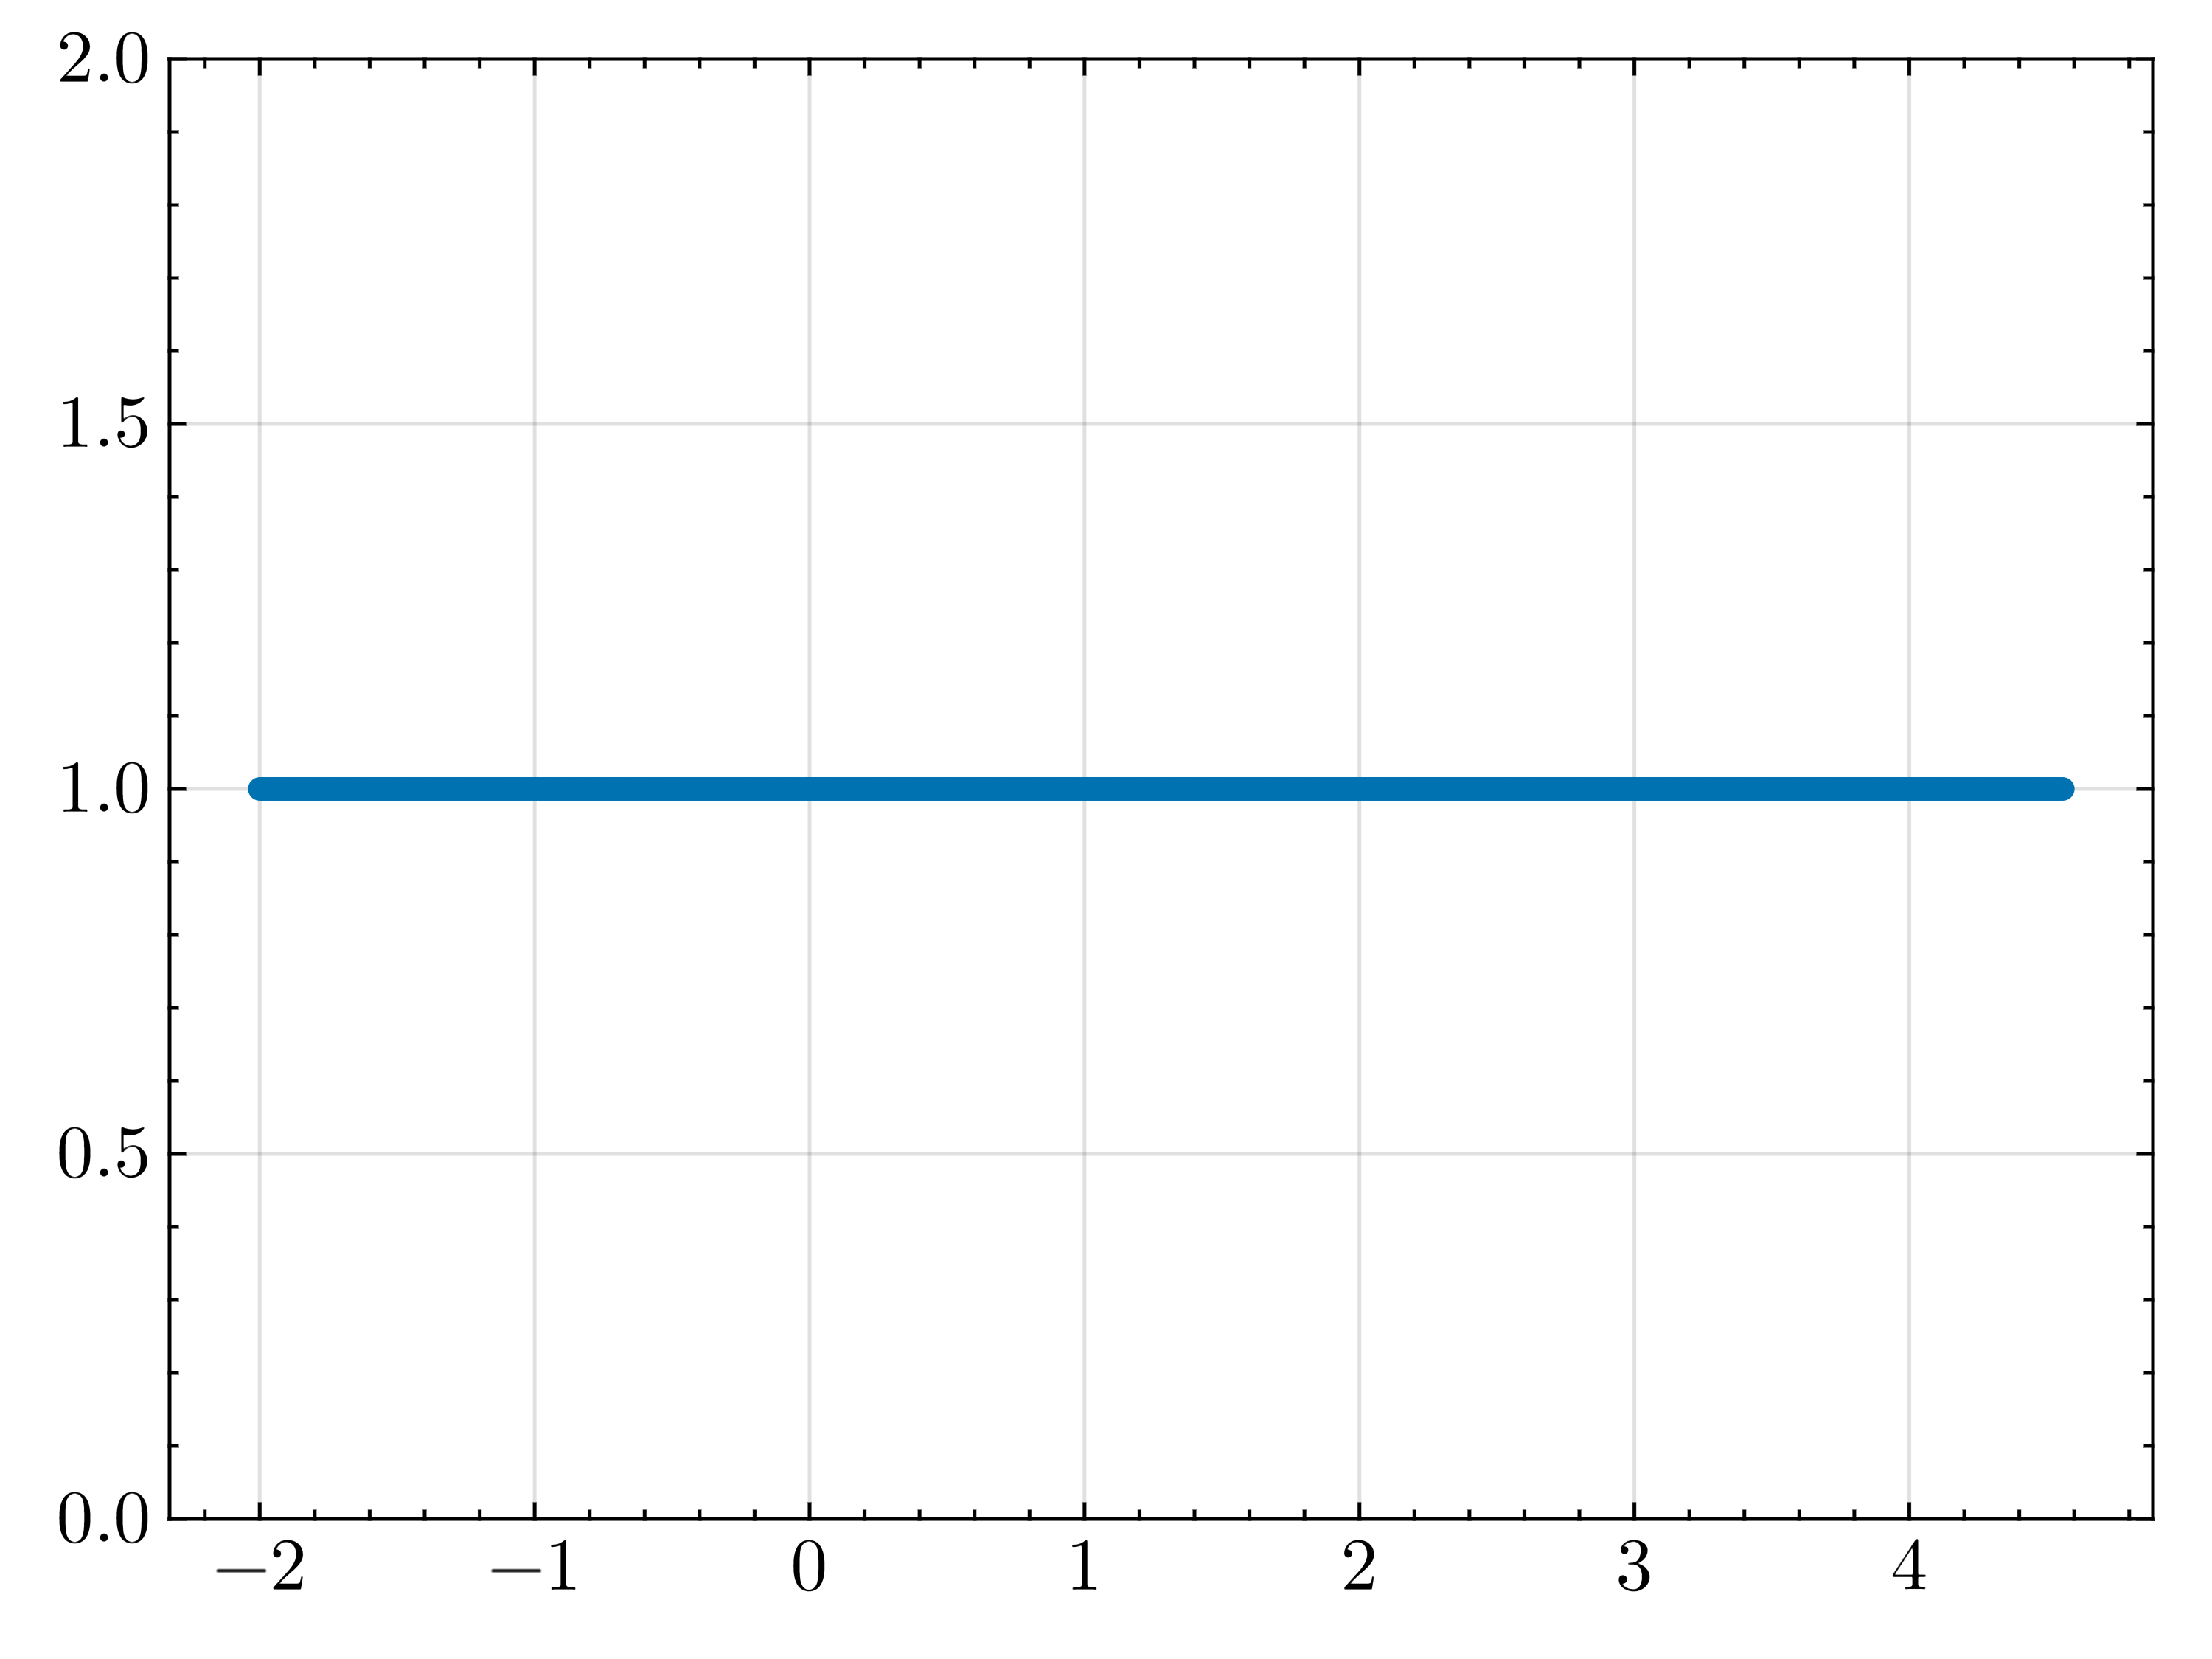

In [819]:
x_m = LinRange(-2, 5, 1000)

y = s1.(x_m)
y2 = s2.(x_m)


fig, ax = FigAxis(
    limits=(nothing, (0, 2))
)
plot!(x_m, y ./ y2)
fig

In [820]:
s2(2.)

0.05741534519549134

In [821]:
DE.eval_spline(DE.integral(s_best).knots, c2, 4, k_0[2])

0.0056149250360129225

In [822]:
DE.integral(s_best)(k_0[2])

0.005614925036012923

In [823]:
DE.integral(s_best).coefs

13-element Vector{Float64}:
 0.0
 8.25981473870058e-6
 0.0004095772459262958
 0.0078465607474418
 0.06952500298994925
 0.26665912382128565
 0.5832011918762258
 0.8519758720298642
 0.9703741513846401
 0.9977064968896341
 0.9999040199851791
 0.9999955815610196
 0.9999999999999999

In [824]:
k_0

10-element LinRange{Float64, Int64}:
 -4.09765, -3.13534, -2.17304, …, 1.67618, 2.63848, 3.60079, 4.56309

In [825]:
?DE.BSK.BSplines.basis_integral

No documentation found.

`BSplineKit.BSplines.basis_integral` is a `Function`.

```
# 2 methods for generic function "basis_integral" from BSplineKit.BSplines:
 [1] basis_integral(B::BSplineKit.BSplines.PeriodicBSplineBasis)
     @ ~/.julia/packages/BSplineKit/YWSZL/src/BSplines/periodic.jl:264
 [2] basis_integral(B::BSplineKit.BSplines.BSplineBasis)
     @ ~/.julia/packages/BSplineKit/YWSZL/src/BSplines/basis.jl:113
```


In [826]:
h = DE.histogram(x, normalization=:pdf)
length(h.bins), length(h.values)

(67, 66)

In [828]:
DE.integral(s_best)(k_0[end])

0.9999999999999999

In [829]:
minimum(s_best.(x))

1.8366081943779707e-5

TODO: apply constraints to assert all a>0, look into how to handle the boundaries (maybe reducing degrees of freedom)
and apply constraint for normalization?
Need analytic derivatives and hessian


In [830]:
s_best = s_primal

DensityEstimators.BSpline(12-element Spline{Float64}:
 basis: 12-element BSplineBasis of order 4, domain [-4.097646682818083, 4.5630902002569105]
 order: 4
 knots: [-4.09765, -4.09765, -4.09765, -4.09765, -3.13534, -2.17304, -1.21073, -0.24843, 0.713874, 1.67618, 2.63848, 3.60079, 4.56309, 4.56309, 4.56309, 4.56309]
 coefficients: [3.43335e-5, 0.000834076, 0.0103044, 0.0640945, 0.204856, 0.328942, 0.279303, 0.123036, 0.028403, 0.00304481, 0.000190297, 1.83661e-5])

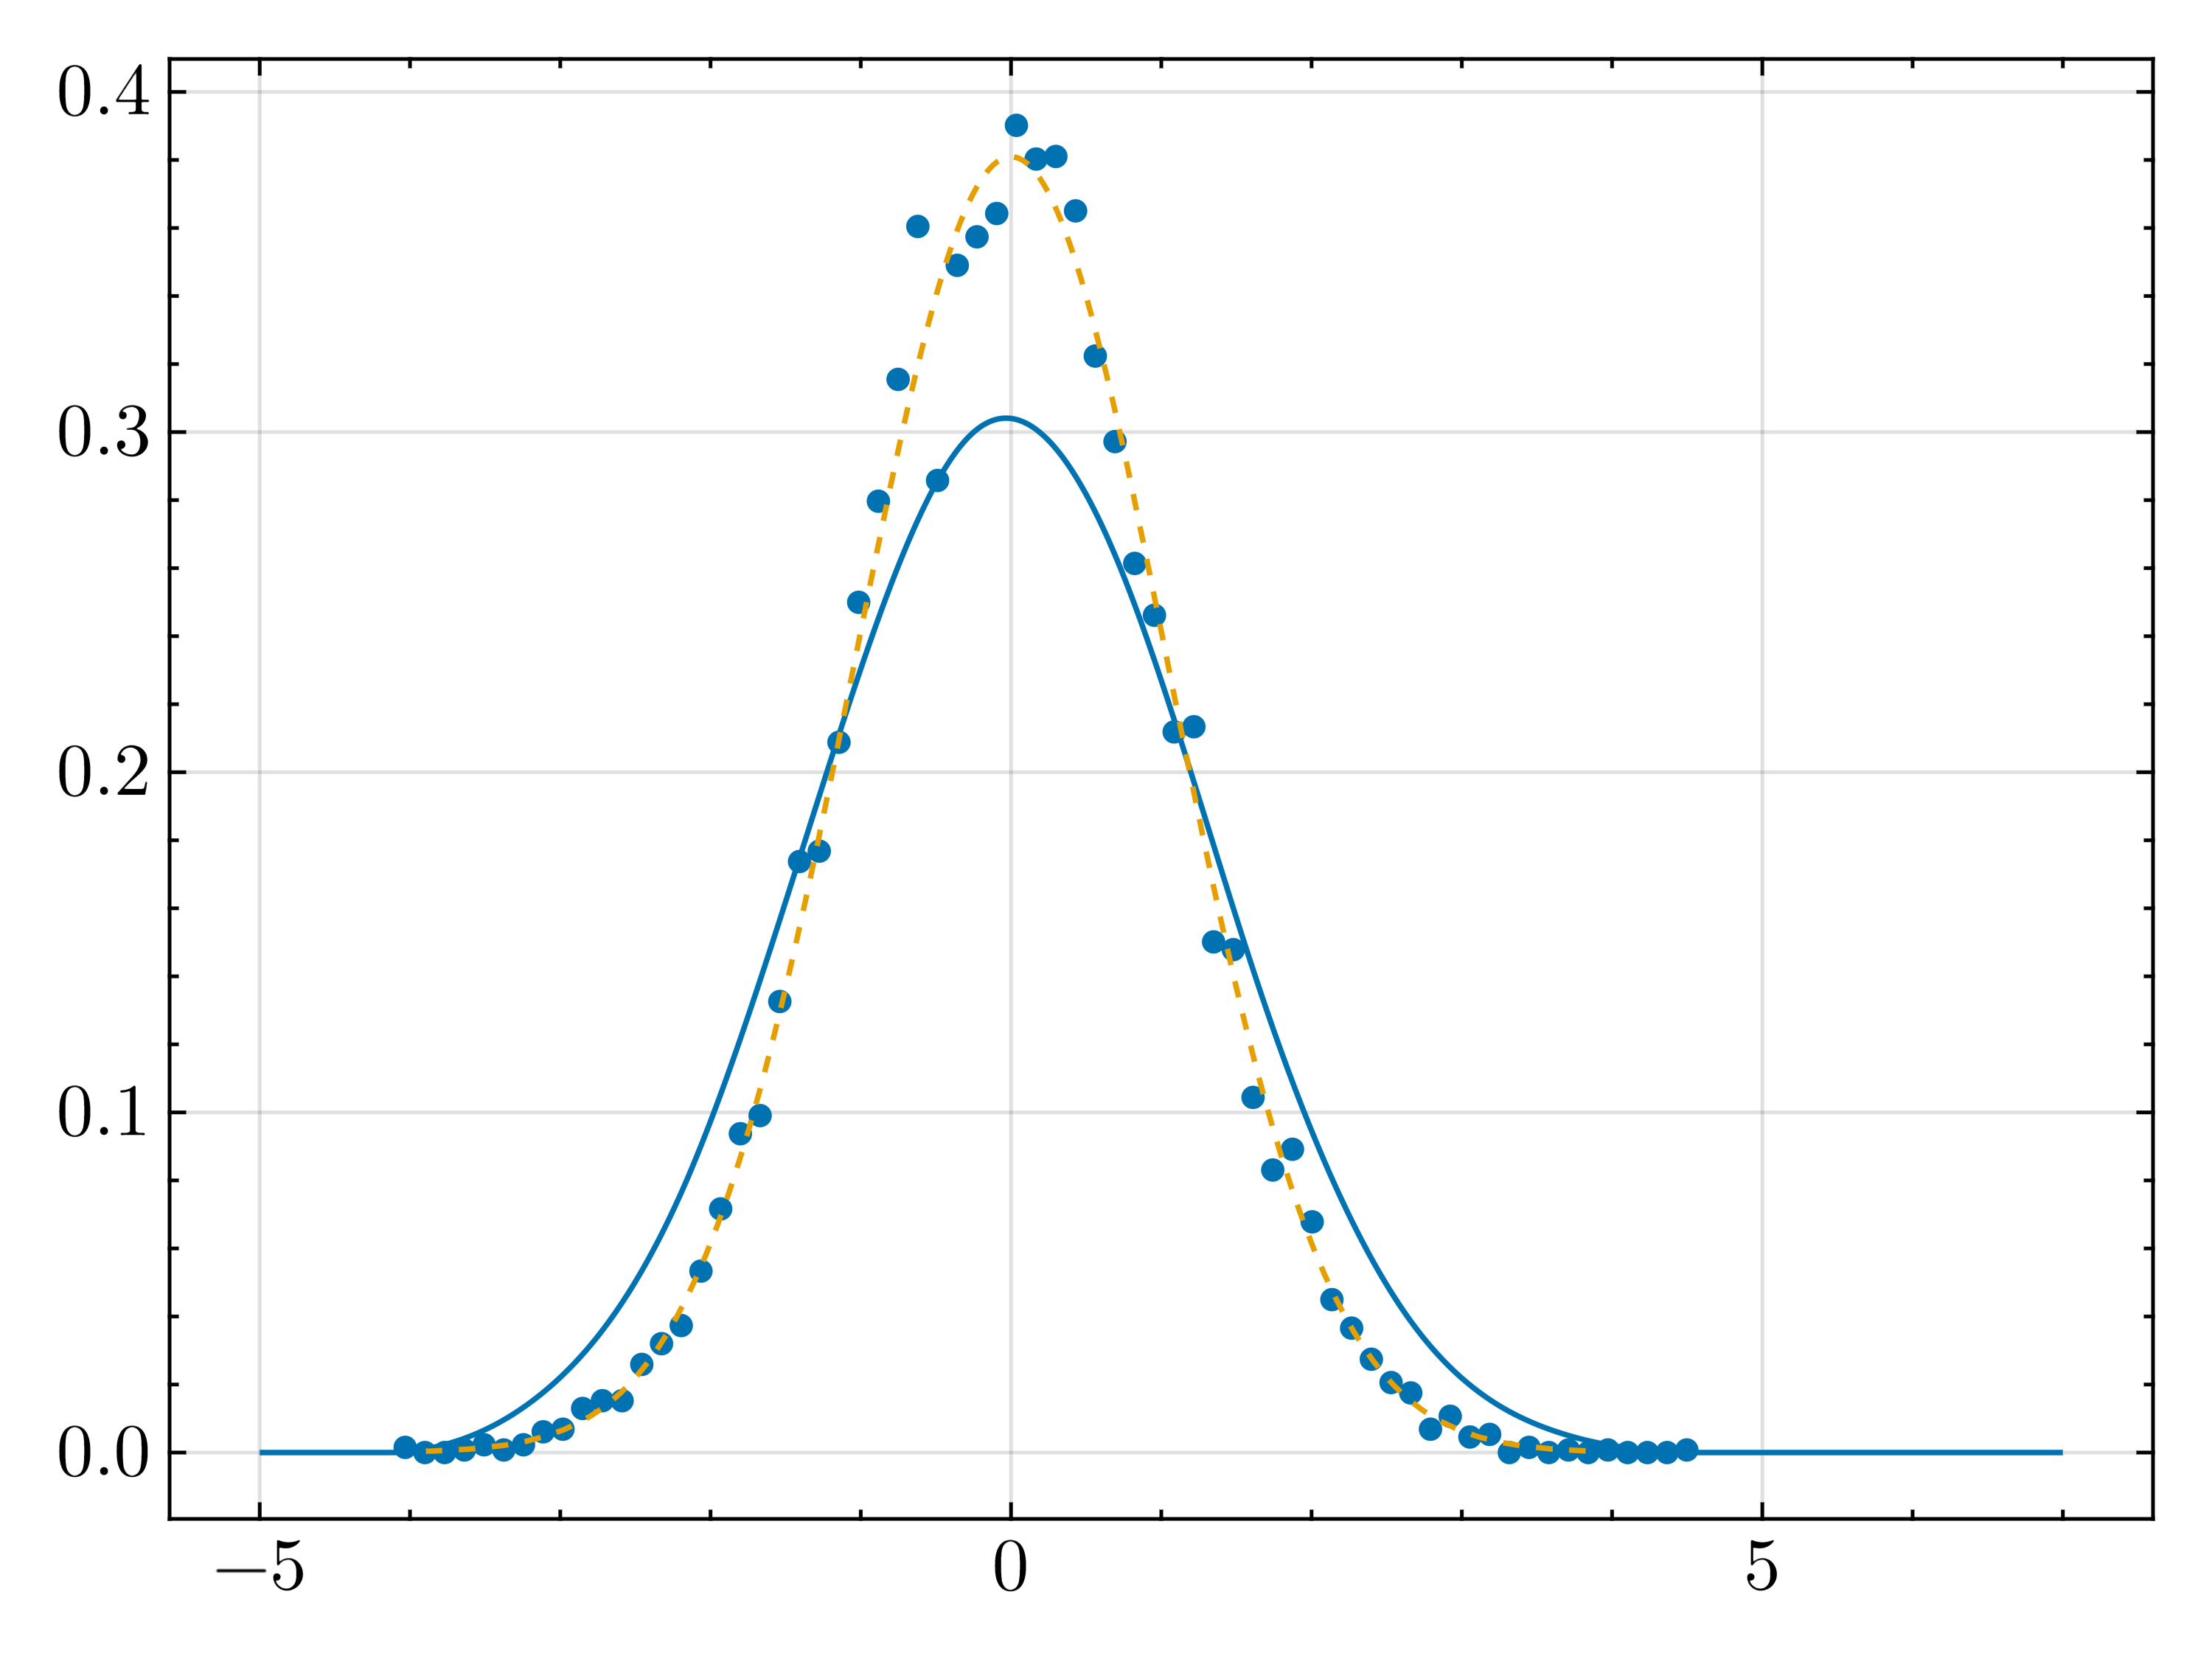

In [831]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
plot!(midpoints(h.bins), h.values)

x_m = LinRange(-5, 7, 1000)
y_m = s_best.(x_m)
lines!(x_m, y_m)
lines!(dist_normal, color=COLORS[2], linestyle=:dash)

fig

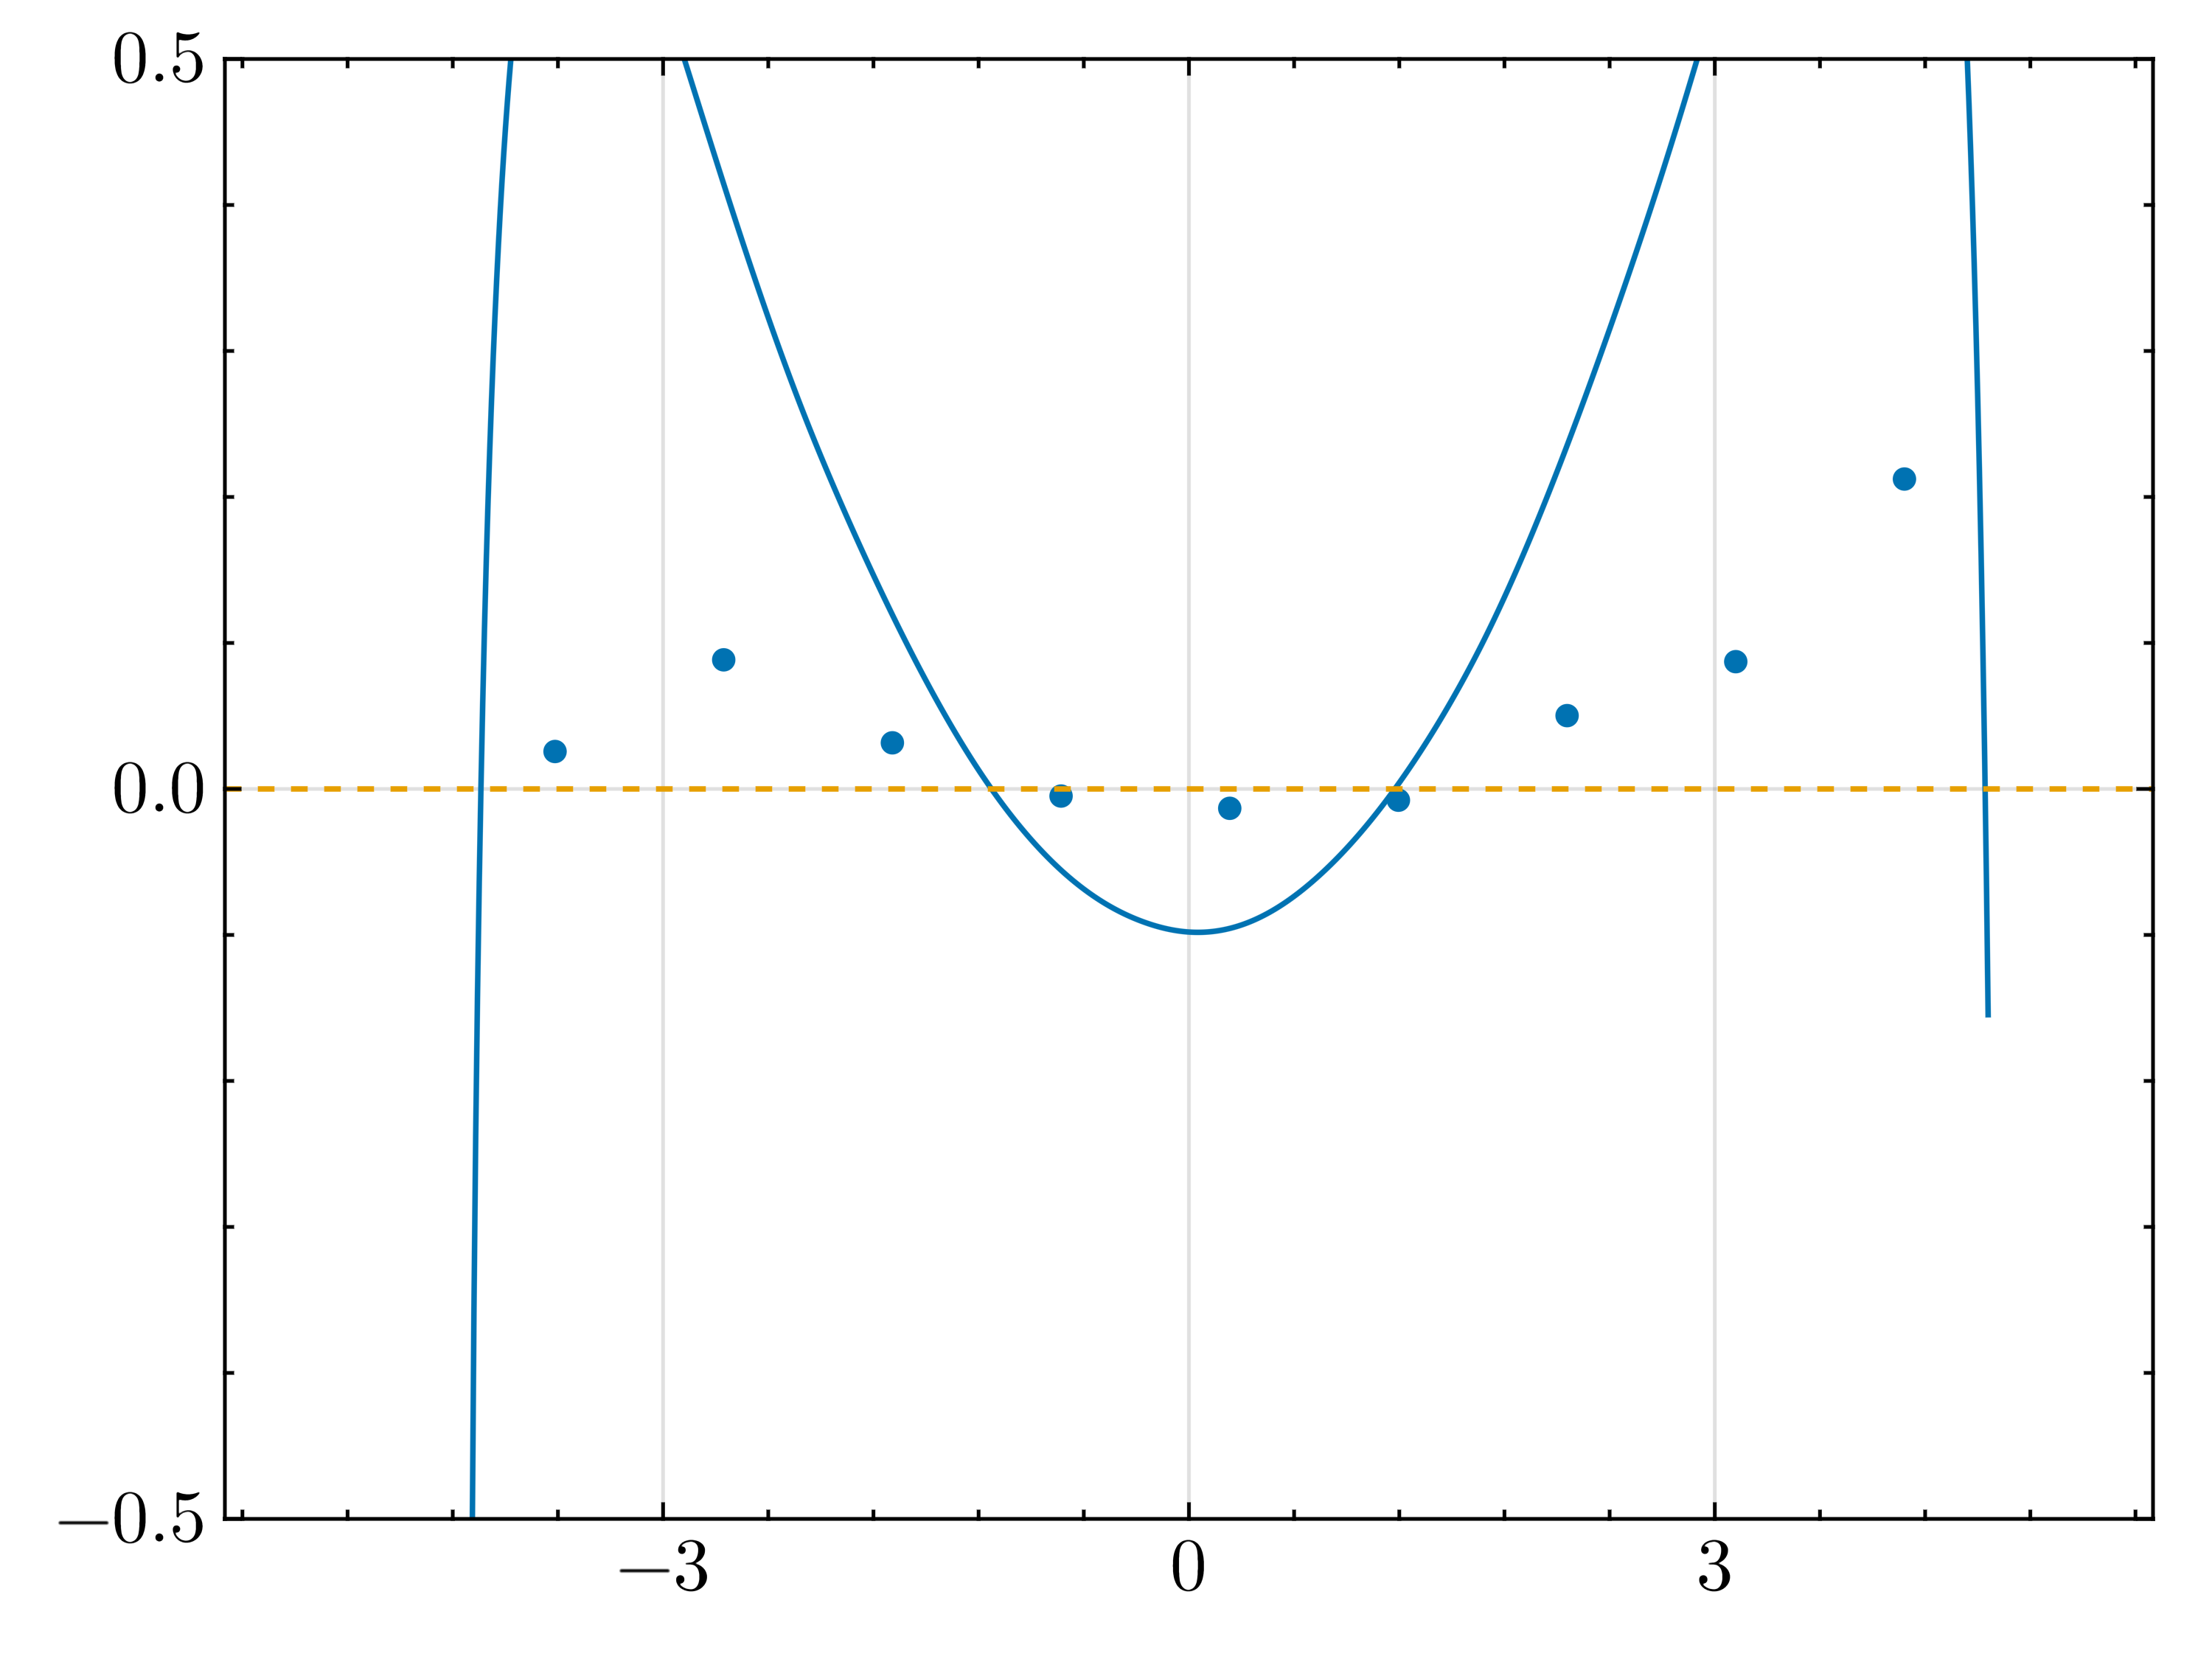

In [423]:
fig, ax = FigAxis(
limits=(nothing, (-0.5, 0.5))
    )

h = DE.histogram(x, Nk-1, normalization=:pdf)
y_h = log10.(h.values ./ pdf.(dist_normal, midpoints(h.bins)))
plot!(midpoints(h.bins), y_h)

x_m = LinRange(-5, 5, 1000)
y_m = log10.(s_best.(x_m) ./ pdf.(dist_normal, x_m))
lines!(x_m, y_m)

hlines!(0, color=COLORS[2], linestyle=:dash)

fig

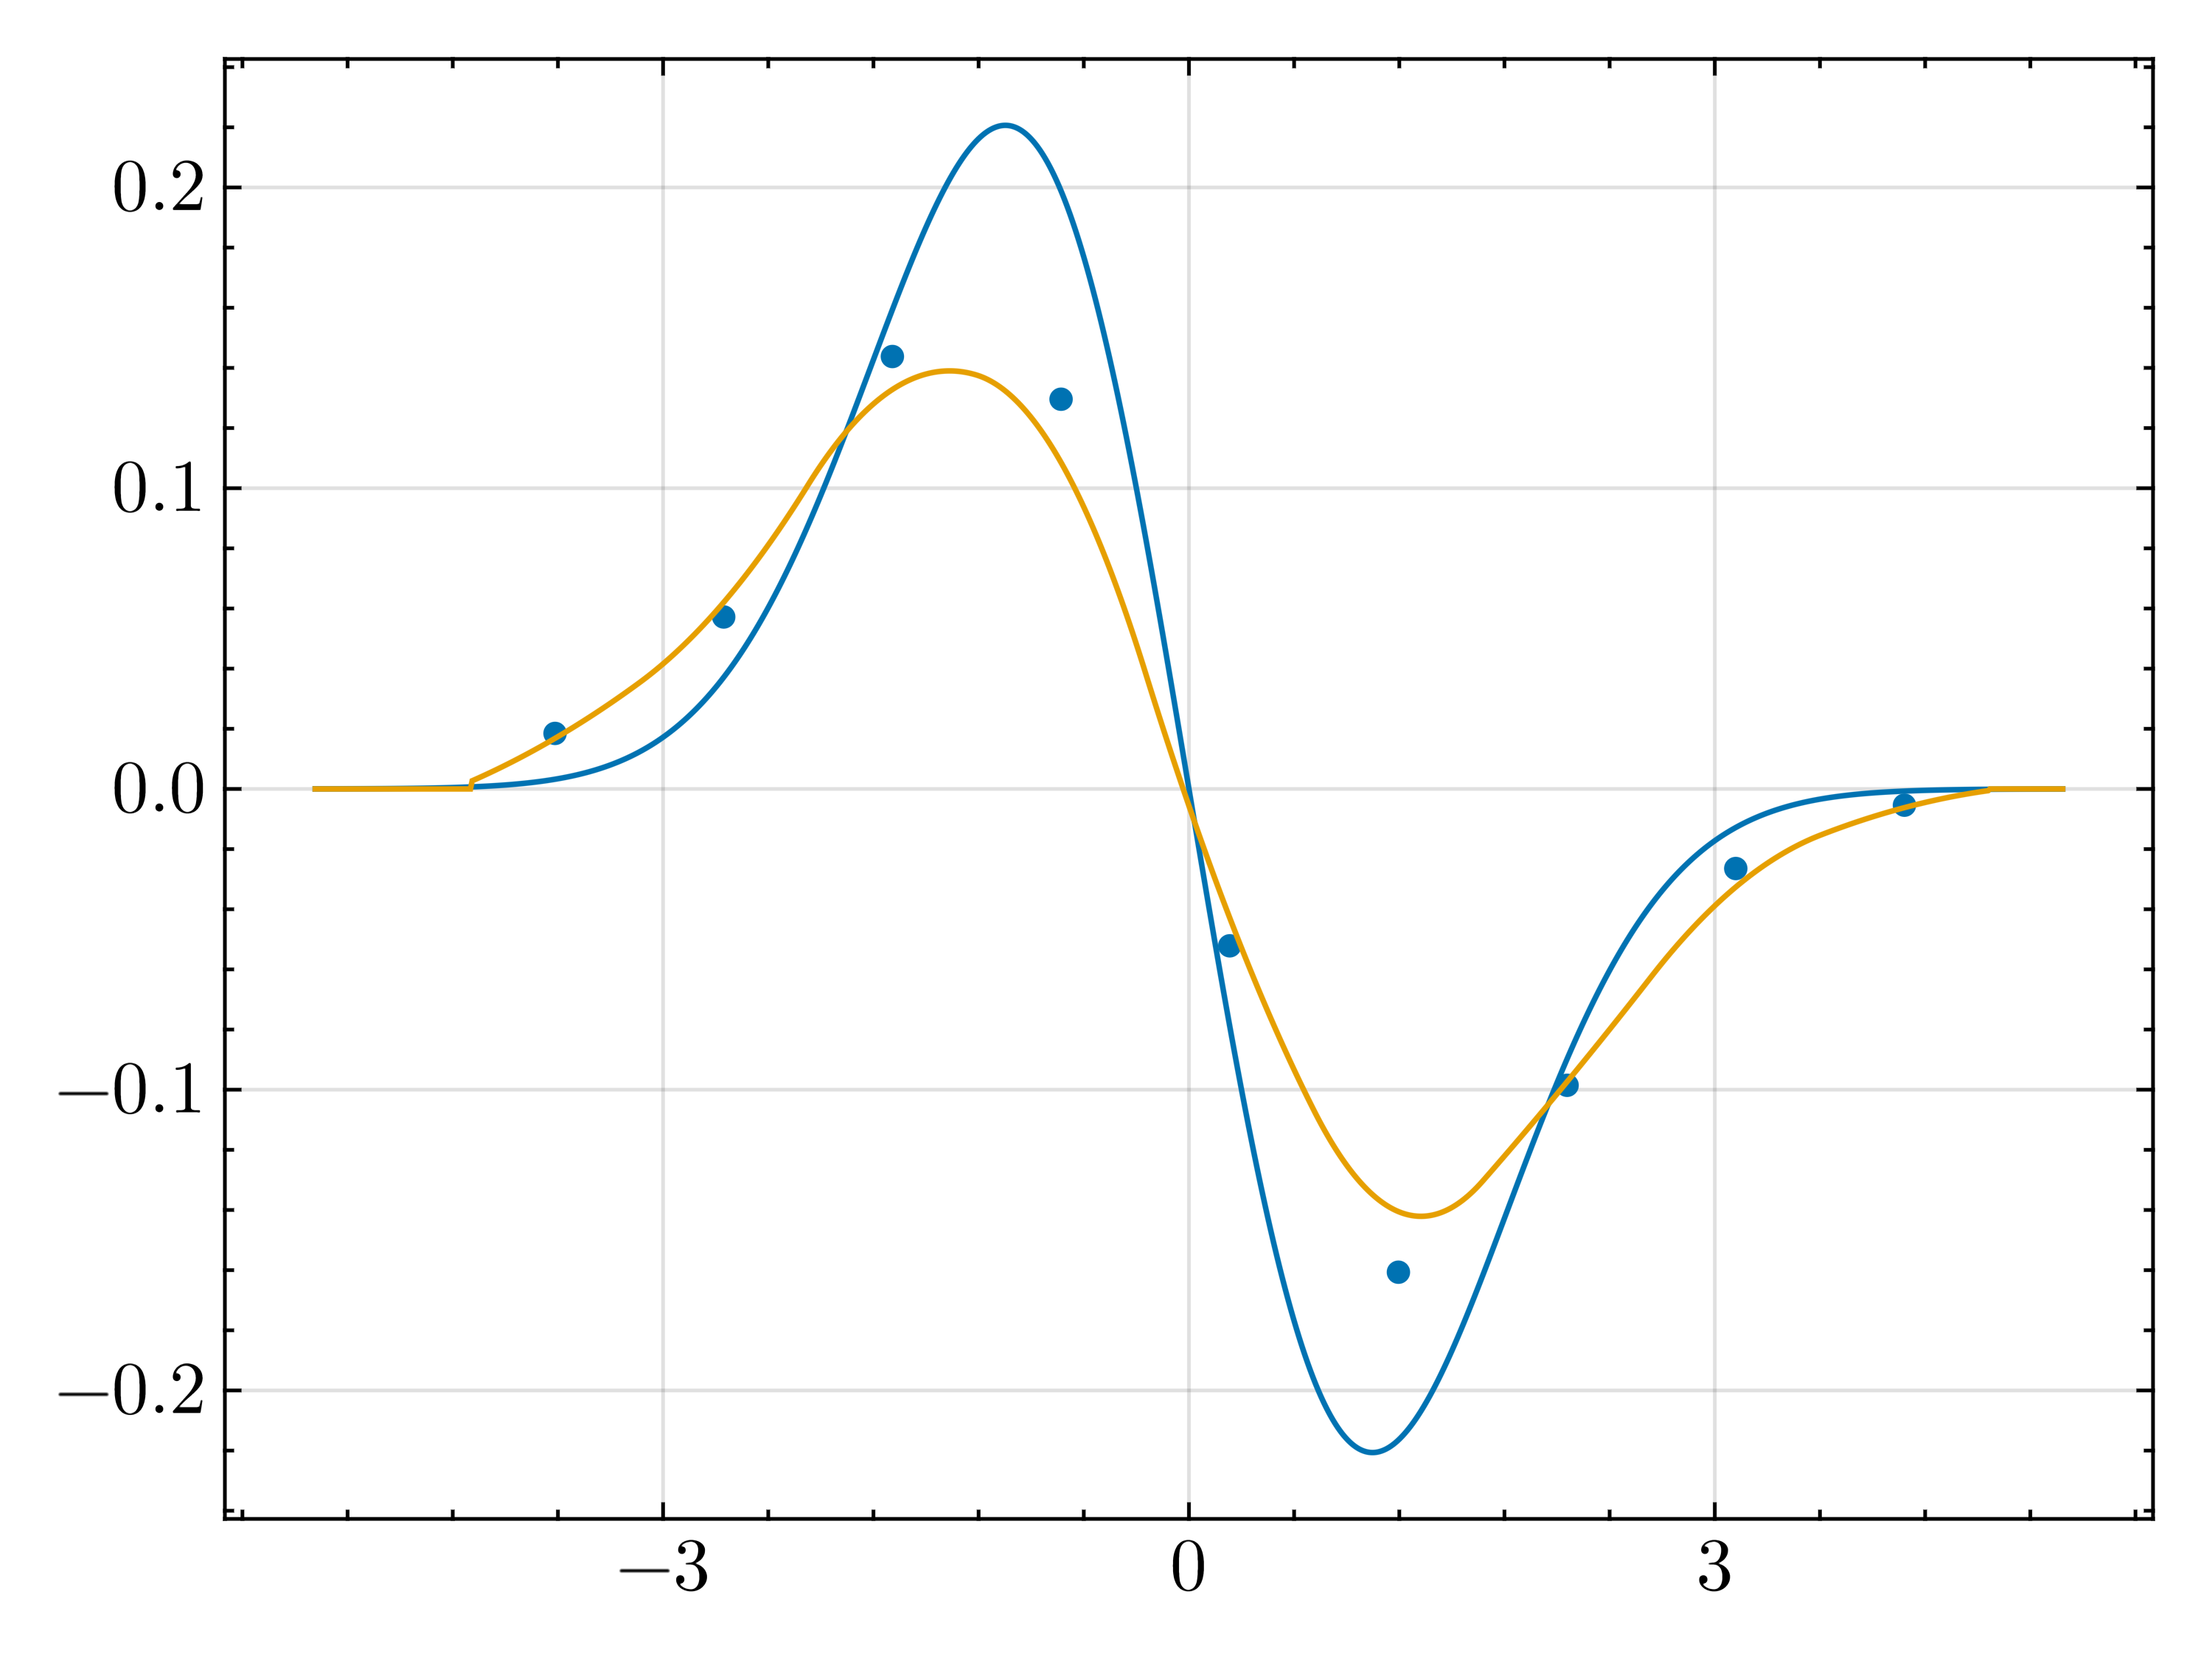

In [418]:
fig, ax = FigAxis()

x_h = midpoints(h.bins)
y_h = h.values

plot!(x_h, DE.gradient(y_h, x_h))
plot_derivative!(dist_normal)

y_m = DE.derivative(s_best, 1).(x_m)

lines!(x_m, y_m)

fig

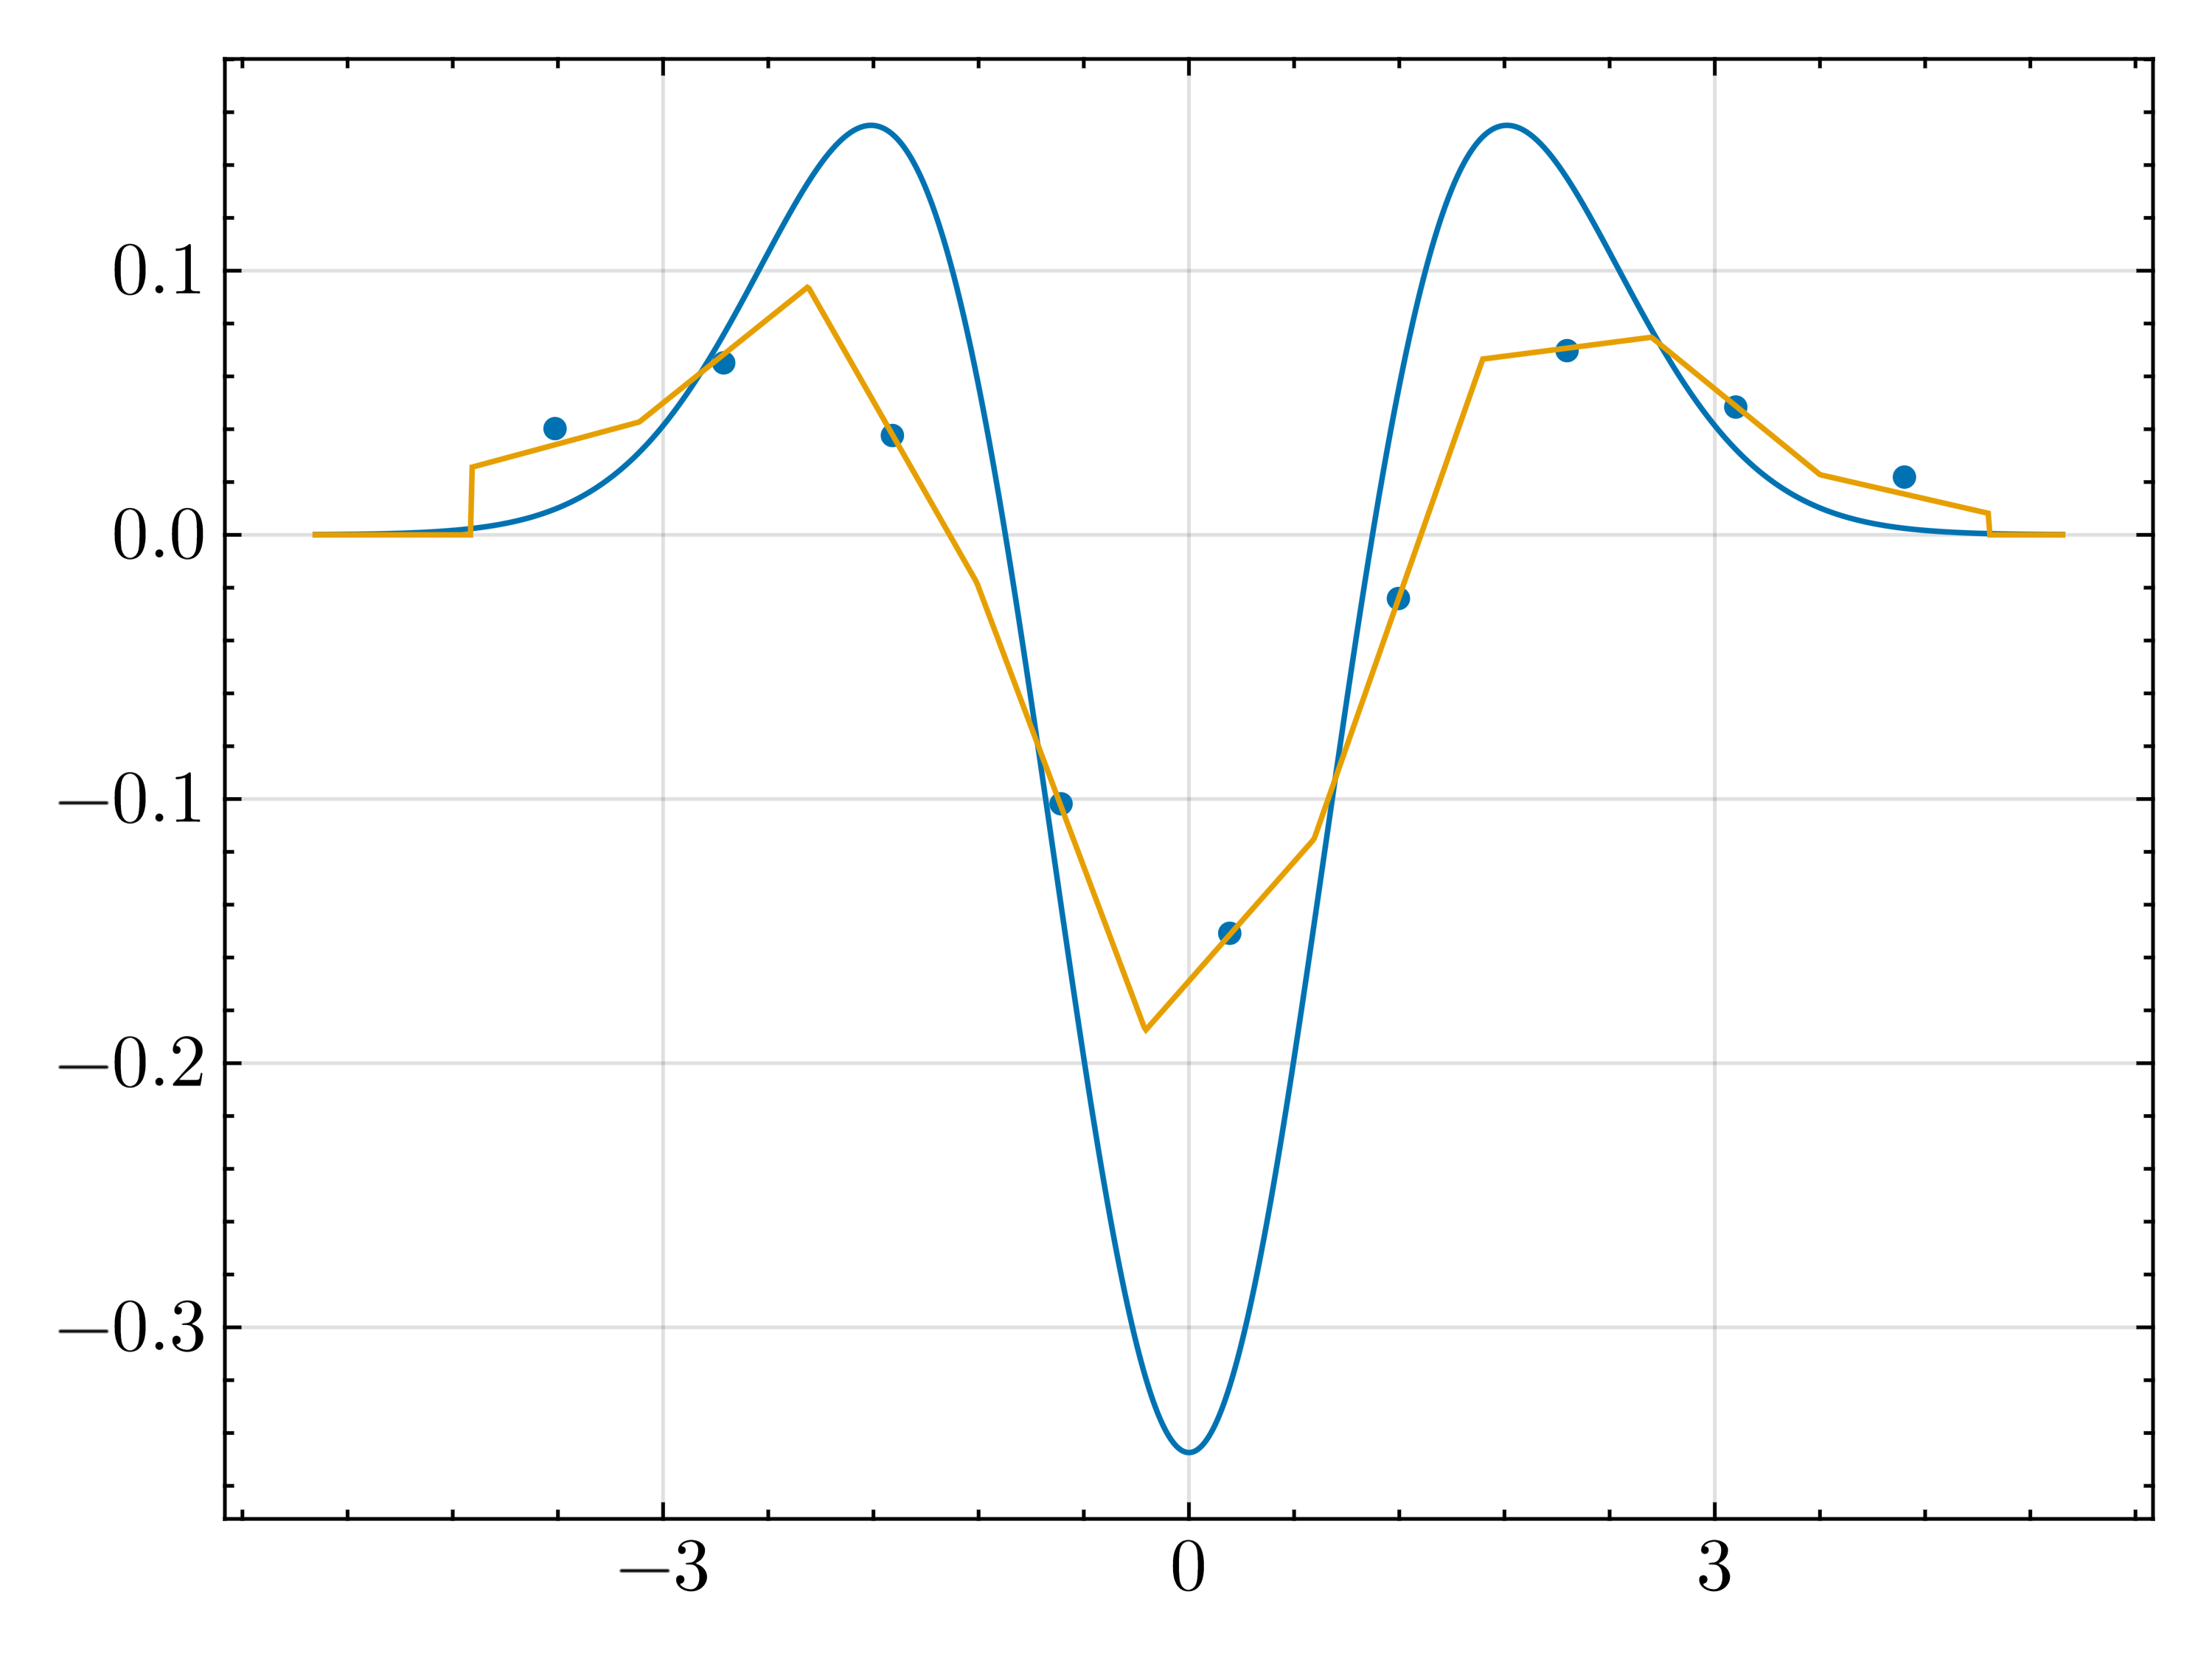

In [408]:
fig, ax = FigAxis()

plot!(x_h, DE.gradient(DE.gradient(y_h, x_h), x_h))
plot_d2!(dist_normal)

y_m = DE.derivative(s_best, 2).(x_m)

lines!(x_m, y_m)

fig

# Log Splines

In [174]:
struct LogSpline
    knots::Vector{Float64}
    coef::Vector{Float64}
    order::Int
    _spline
    _norm
end

In [175]:
function LogSpline(knots, coefs, order=3)
    s = DE.BSpline(knots, coefs, order)
    
    spline_unnorm = LogSpline(knots, coefs, order, s, 1) 
    A = quadgk(spline_unnorm, knots[1], knots[end])[1]
    
    return LogSpline(knots, coefs, order, s, 1/A)
end

LogSpline

In [176]:
import QuadGK: quadgk

In [177]:
function log_L(spline::LogSpline, x; s=0.0)
    N = length(x)
    s_x = spline.(x)
    if any(s_x .< 0)
        return -Inf
    end
    
    A = quadgk(spline, spline.knots[1], spline.knots[end])[1]
    
    return 1/N * sum(log.(s_x)) - 3abs.(log.(A)) # constraint
end

log_L (generic function with 2 methods)

In [178]:
function optimize_lspline(knots, coef_i, order, samples)
    
    function obj(coef)
        s = LogSpline(knots, coef, order)
        -log_L(s, samples)
    end
    
    result = optimize(obj, coef_i)
    
    return result.minimizer, result
end

optimize_lspline (generic function with 1 method)

In [179]:
function (s::LogSpline)(x)
    return exp.(s._spline(x)) .* s._norm
end

In [188]:
Nk = 20
k_0 = LinRange(minimum(x), maximum(x), Nk)
#k_0 = quantile(x, LinRange(0, 1, Nk));

degree = 3

3

In [190]:
a_0 = randn(Nk + 2);

In [192]:
a, res = optimize_lspline(k_0, a_0, 3, x)

([-0.7143352536682291, -5.696107869702179, 0.028967773679966655, -4.3865394516397265, -3.134959710289509, 0.003950007861059979, 0.23409756730523915, 0.3868625785606471, 1.7897250750702791, 2.4263182553367333  …  2.341006926951748, 1.9890263787551998, 1.1605129167378159, 0.5305479876920005, -2.635071143759114, -0.025329170813605445, -2.1472258893243055, -3.039783831203081, -4.386933637197198, -0.8330975386201227],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.886664e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   34  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1315
)

In [193]:
s_best = LogSpline(k_0, a, 3)

LogSpline([-6.384522923097085, -5.613204808912006, -4.841886694726928, -4.070568580541849, -3.2992504663567708, -2.527932352171692, -1.7566142379866139, -0.9852961238015348, -0.21397800961645652, 0.5573401045686217, 1.3286582187537008, 2.0999763329387795, 2.8712944471238577, 3.6426125613089373, 4.413930675494015, 5.185248789679094, 5.9565669038641715, 6.7278850180492515, 7.499203132234328, 8.270521246419408], [-0.7143352536682291, -5.696107869702179, 0.028967773679966655, -4.3865394516397265, -3.134959710289509, 0.003950007861059979, 0.23409756730523915, 0.3868625785606471, 1.7897250750702791, 2.4263182553367333  …  2.341006926951748, 1.9890263787551998, 1.1605129167378159, 0.5305479876920005, -2.635071143759114, -0.025329170813605445, -2.1472258893243055, -3.039783831203081, -4.386933637197198, -0.8330975386201227], 3, DensityEstimators.BSpline(22-element Spline{Float64}:
 basis: 22-element BSplineBasis of order 4, domain [-6.384522923097085, 8.270521246419408]
 order: 4
 knots: [-6.3

In [194]:
s_best._norm

0.019218768964176316

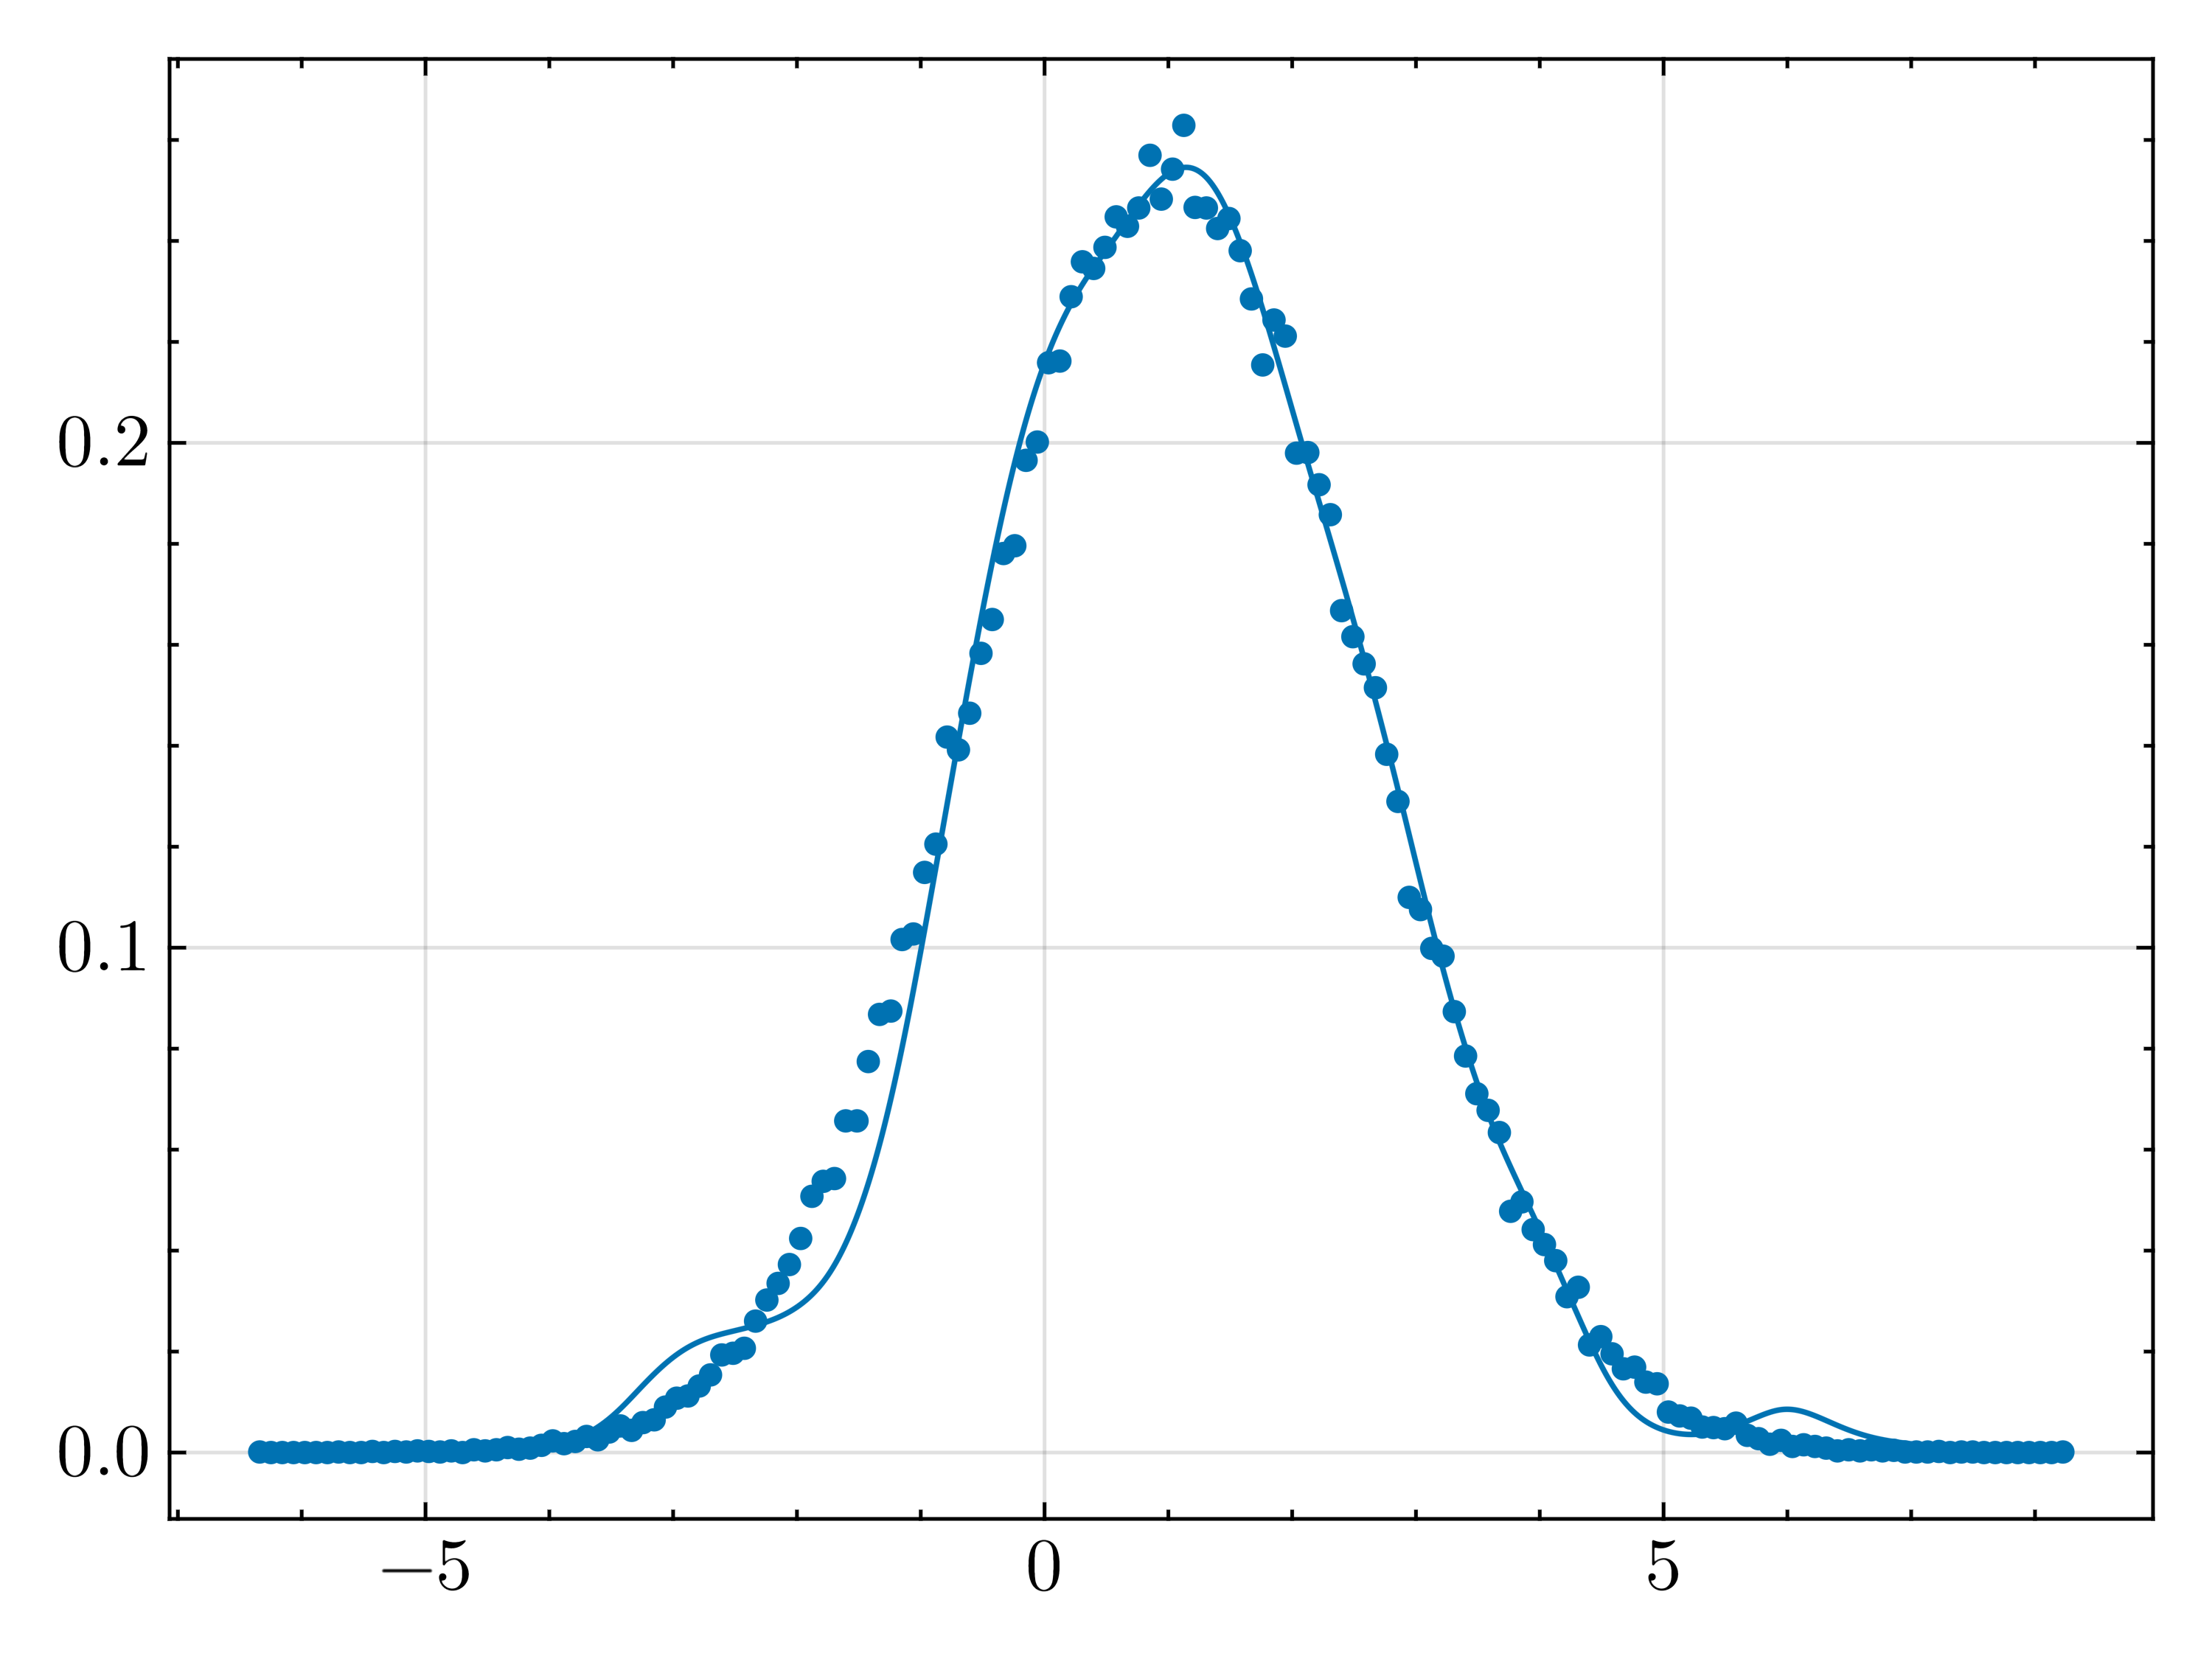

In [195]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
x_m = LinRange(-5, 7, 1000)
y_m = s_best.(x_m)
lines!(x_m, y_m)

plot!(midpoints(h.bins), h.values)
fig

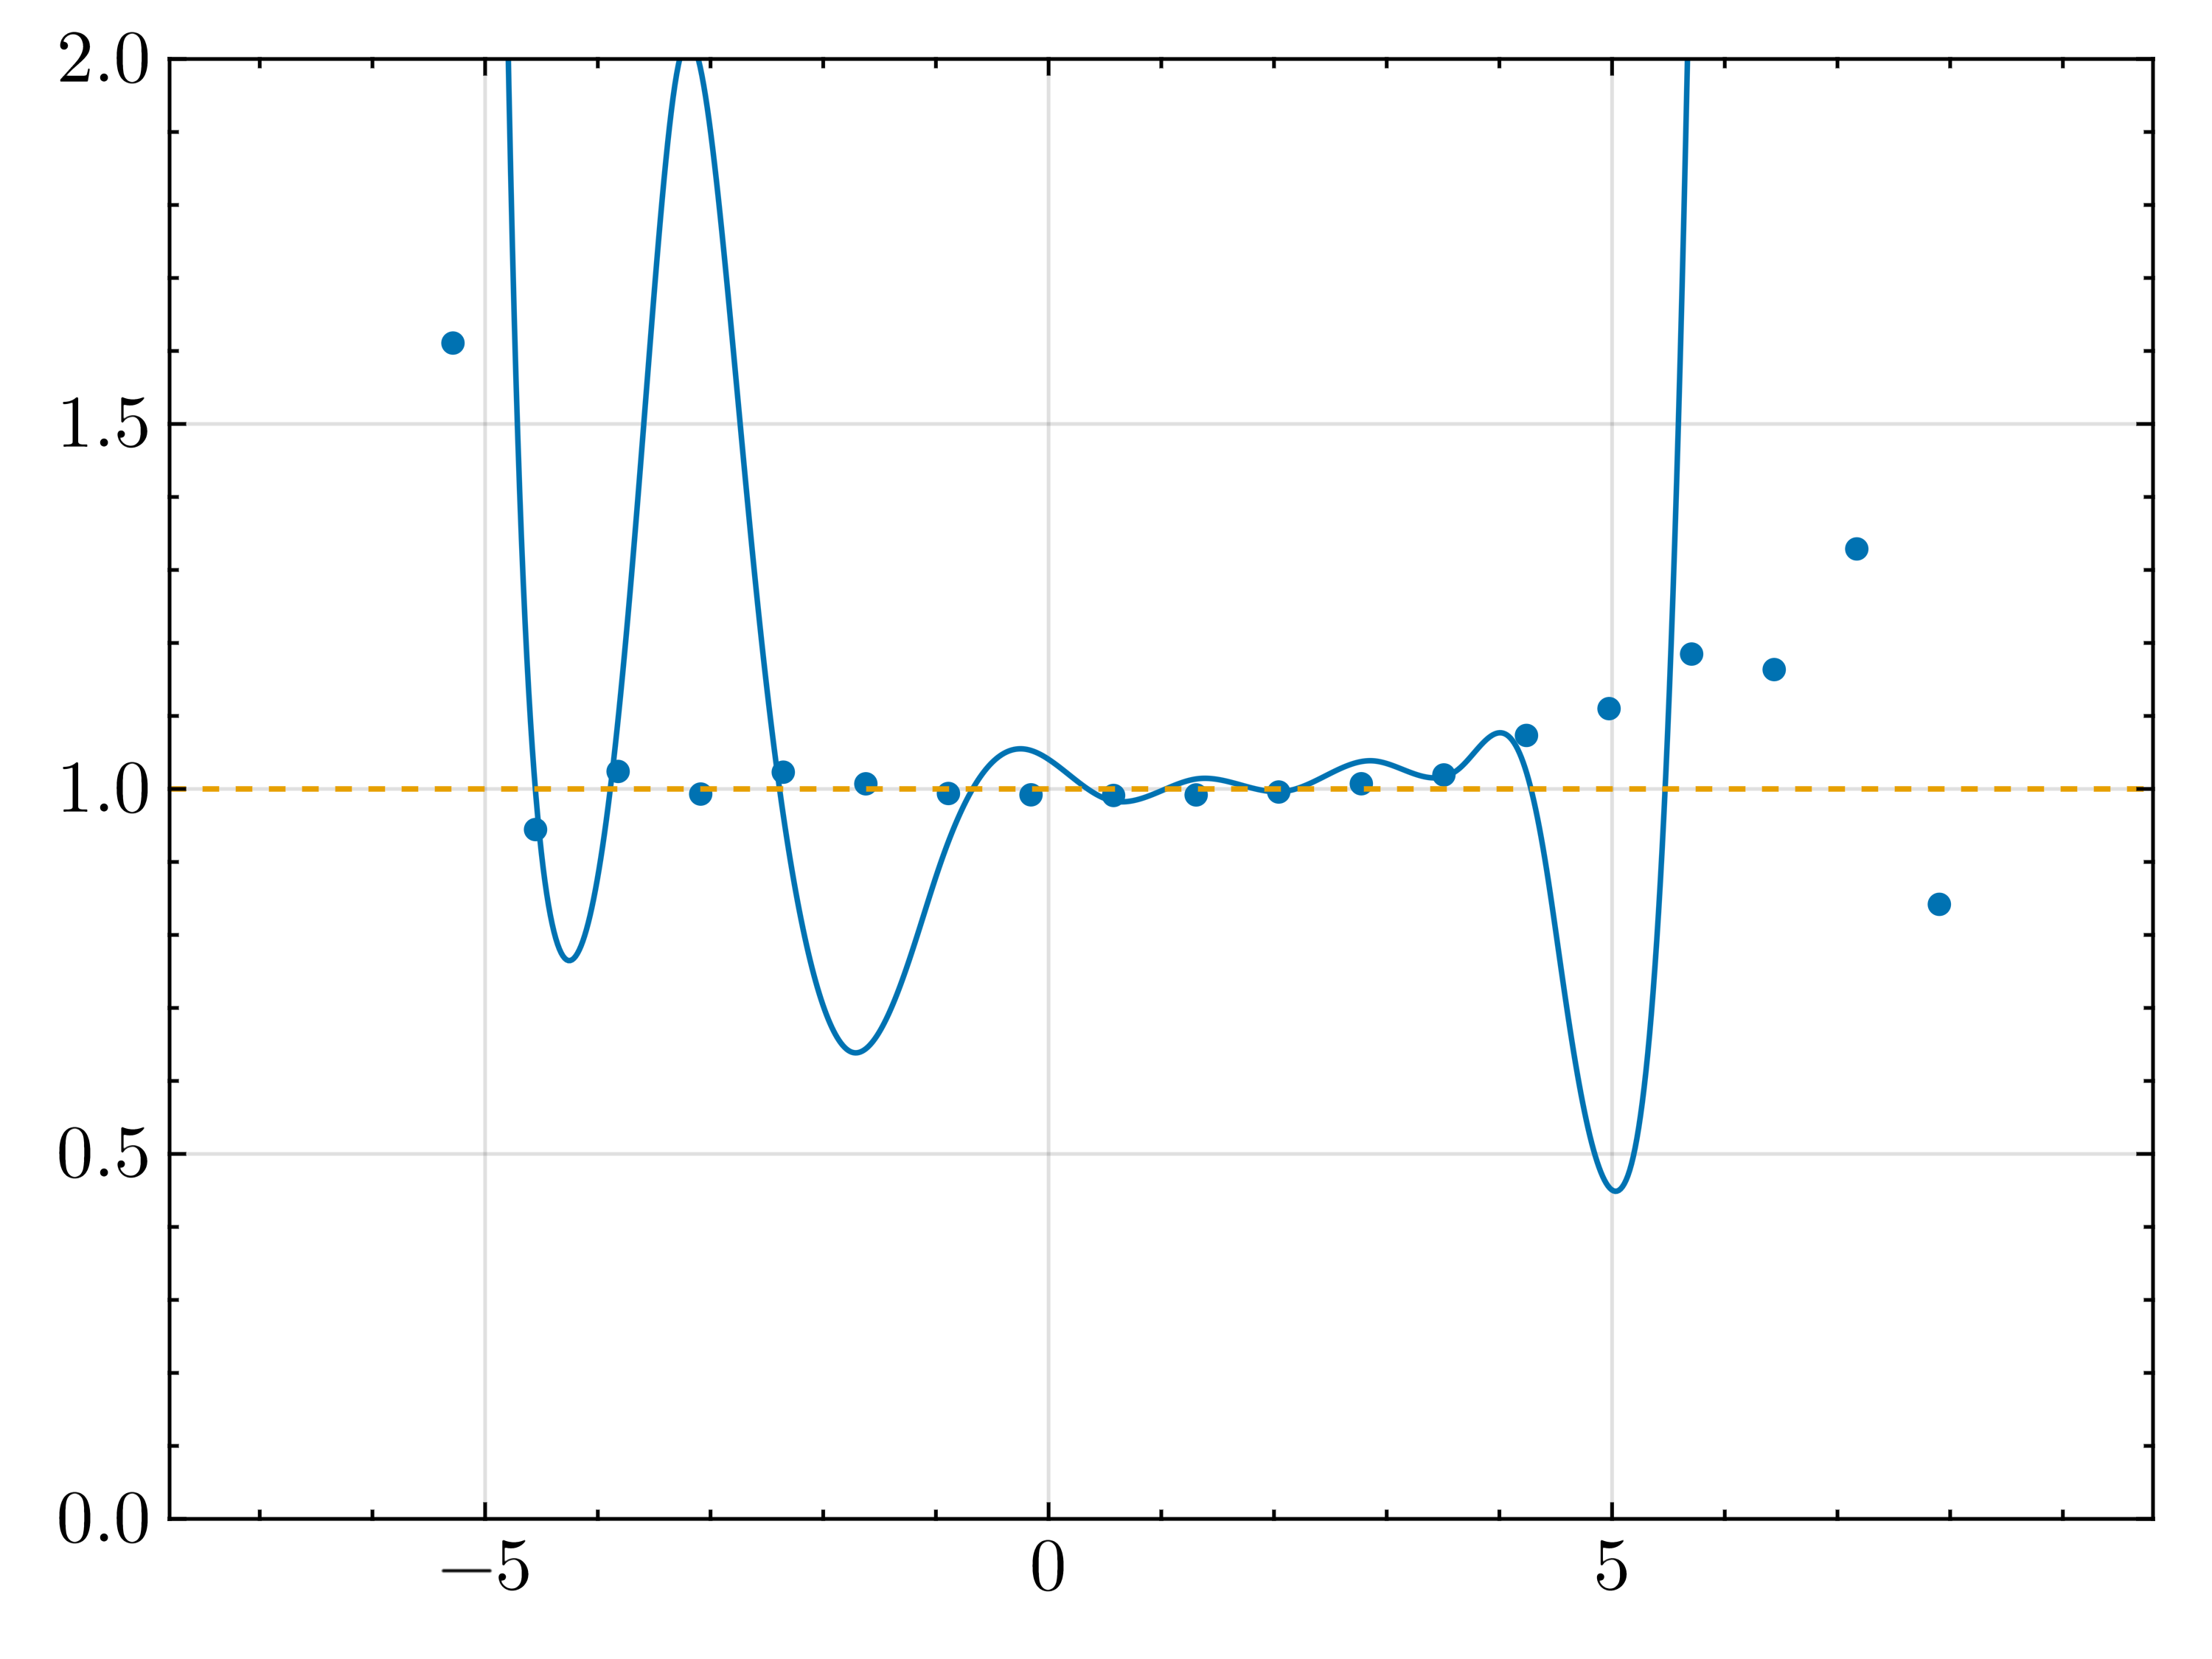

In [197]:
fig, ax = FigAxis(
limits=(nothing, (0, 2))
    )

h = DE.histogram(x, Nk, normalization=:pdf)
plot!(midpoints(h.bins), h.values ./ pdf.(dist_normal, midpoints(h.bins)))

x_m = LinRange(-7, 9, 1000)
y_m = s_best.(x_m) ./ pdf.(dist_normal, x_m)
lines!(x_m, y_m)
hlines!(1, color=COLORS[2], linestyle=:dash)

fig